# 1. Введение

Представим, что мы работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить. Наша задача - построить такую модель.

Для начала импортируем все необходимые библиотеки.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from collections import Counter

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# ДОПОЛНИТЕЛЬНЫЕ БИБЛИОТЕКИ
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# дополнительно импортированные библиотеки
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
RANDOM_SEED = 42

hotels_train = pd.read_csv('hotels_train.zip')
hotels_test = pd.read_csv('hotels_test.zip')
sample_submission = pd.read_csv('submission.csv')

In [6]:
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем где у нас трейн
hotels_test['sample'] = 0 # помечаем где у нас тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([hotels_train, hotels_test], ignore_index=True)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,1


Датасет содержит следующие признаки:
- *hotel_address* — адрес отеля;
- *review_date* — дата, когда рецензент разместил соответствующий отзыв;
- *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- *hotel_name* — название отеля;
- *reviewer_nationality* — страна рецензента;
- *negative_review* — отрицательный отзыв, который рецензент дал отелю;
- *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
- *positive_review* — положительный отзыв, который рецензент дал отелю;
- *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
- *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
- *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
- *total_number_of_reviews* — общее количество действительных отзывов об отеле;
- *tags* — теги, которые рецензент дал отелю;
- *days_since_review* — количество дней между датой проверки и датой очистки;
- *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- *lat* — географическая широта отеля;
- *lng* — географическая долгота отеля.

# 2. Исследование данных

## 2.1 Исследование исходных данных

Рассмотрим основную информацию о датасете.

In [8]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Мы видим, что пропуски отсутствуют практически во всех признаках датасета, за исключением признаков *lat* и *lng*. Выясним, сколько их в процентном соотношении от общего количества данных.

In [9]:
hotels.isna()[['lat', 'lng']].value_counts(normalize=True)*100

lat    lng  
False  False    99.366345
True   True      0.633655
dtype: float64

Оказывается, в признаках *lat* и *lng* пропуски присутствуют одновременно и составляют менее 1% (0.63%) от общего количества данных.

Есть несколько вариантов действия с пропусками:
- пропущенные значениями можно заполнить 0, "unknown" или прочерком;
- строки с пропущенными значениями можно удалить;
- попытаться заполнить, используя данные о географическом положении (определить координаты).

Выберем третий вариант и попробуем заполнить недостающие данные. Для этого воспользуемся библиотекой *geopy* и по адресу отеля получим его координаты.

К сожалению, в Kaggle не получается воспользоваться библиотекой *geopy* (возникает ошибку `GeocoderUnavailable`), поэтому недостающие координаты найдем на персональном компьютере, сохраним данные в файл и загрузим на Kaggle.

Загрузим данные с найденными координатами:

In [10]:
# загружаем датафрейм с координатами
data = pd.read_csv('coordinates.csv', header=0, names=['hotel_address', 'lat', 'lng']).set_index('hotel_address')

# вывод датафрейма
data

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.838331,2.330948
23 Rue Damr mont 18th arr 75018 Paris France,48.856663,2.351556
4 rue de la P pini re 8th arr 75008 Paris France,48.856663,2.351556
Bail n 4 6 Eixample 08010 Barcelona Spain,41.396133,1.655829
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.222139,16.357513
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.778035,15.655650
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.210918,16.347119
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.210918,16.347119
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.206487,16.363460


In [11]:
# НА ВСЯКИЙ СЛУЧАЙ ЗДЕСЬ СЛОВАРЬ С КООРДИНАТАМИ!!!

# coordinates = {'20 Rue De La Ga t 14th arr 75014 Paris France': (48.838331, 2.330948),
#  '23 Rue Damr mont 18th arr 75018 Paris France': (48.856663, 2.351556),
#  '4 rue de la P pini re 8th arr 75008 Paris France': (48.856663, 2.351556),
#  'Bail n 4 6 Eixample 08010 Barcelona Spain': (41.396133, 1.655829),
#  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': (48.222139, 16.357513),
#  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': (48.778035, 15.65565),
#  'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': (48.210918,
#   16.347119),
#  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': (48.210918,
#   16.347119),
#  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': (48.206487,
#   16.36346),
#  'Paragonstra e 1 11 Simmering 1110 Vienna Austria': (48.176599, 16.413999),
#  'Pau Clar s 122 Eixample 08009 Barcelona Spain': (41.504994, 2.245959),
#  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': (48.211783, 16.297308),
#  'Sep lveda 180 Eixample 08011 Barcelona Spain': (41.425226, 2.181864),
#  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': (48.245935, 16.341397),
#  'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': (48.218213, 16.39411),
#  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': (48.222139,
#   16.357513),
#  'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': (48.222139,
#   16.357513)}

# coordinates

Заполним пропущенные координаты во всем датасете:

In [12]:
# создание маски для отбора строк с пропусками в признаках lat и lng
mask = hotels['lat'].isna() & hotels['lng'].isna()

# Применим маску и заполним недостающие координаты:
hotels.loc[hotels[mask].index, ['lat', 'lng']] = hotels[mask]['hotel_address'].apply(lambda x: data.loc[x, ['lat', 'lng']])

Проверим, остались ли пропуски в датасете:

In [13]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Все пропуски заполнены.

Теперь выведем основную статистическую информацию о числовых и нечисловых признаках и, если получится, сделаем некоторые выводы:

In [14]:
display(hotels.describe())
display(hotels.describe(include='object'))

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.432481,2.893274,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.460197,4.667274,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214277,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.019886,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.841163,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


Из статистических данных можно выделить следующее:
- средний балл отеля (`average_score`) варьируется от 5.2 до 9.8 баллов  и равен 8.397 балла;
- оценки пользователей (`reviewer_score`) не выходят за пределы диапазона 0...10 баллов, что видно по минимальному (0) и максимальному (10) баллам оценки посетителей, что говорит об отсутствии выбросов в интересующем нас признаке (`reviewer_score`);
- средний балл отеля (`average_score`) отличается от среднего балла оценки посетителей (`reviewer_score`) в наблюдаемой выборке - 8.397231 против 6.297672. Не забываем, что мы рассматриваем датасет, который получился путем объединения *hotels_train* и *hotels_test*, в котором признак `reviewer_score` равен нулю;
- отзывы оставили посетители из 227 стран (уникальные значения признака `reviewer_nationality`);
- отель, который оценивали чаще всего, находится в *Великобритании* и это *Britannia International Hotel Canary Wharf*;
- в среднем отрицательные и положительные отзывы содержат примерно равное количество слов (признаки `review_total_negative_word_counts` и `review_total_positive_word_counts`);
- самый популярный отрицательный отзыв - *No Negative*; самый популярный положительный отзыв - *No Positive*;
- похоже, что какой-то один отель находится сразу по двум адресам (*unique hotel_address* - 1493, *unique hotel_name* - 1492).  

Посмотрим, как выглядит распределение оценок посетителей. Для этого построим графики с помощью библиотки *seaborn*. В построении графиков участвует только датасет *hotels_train*, так как в датасете *hotels_test* признак `reviewer_score` заполнен 0.

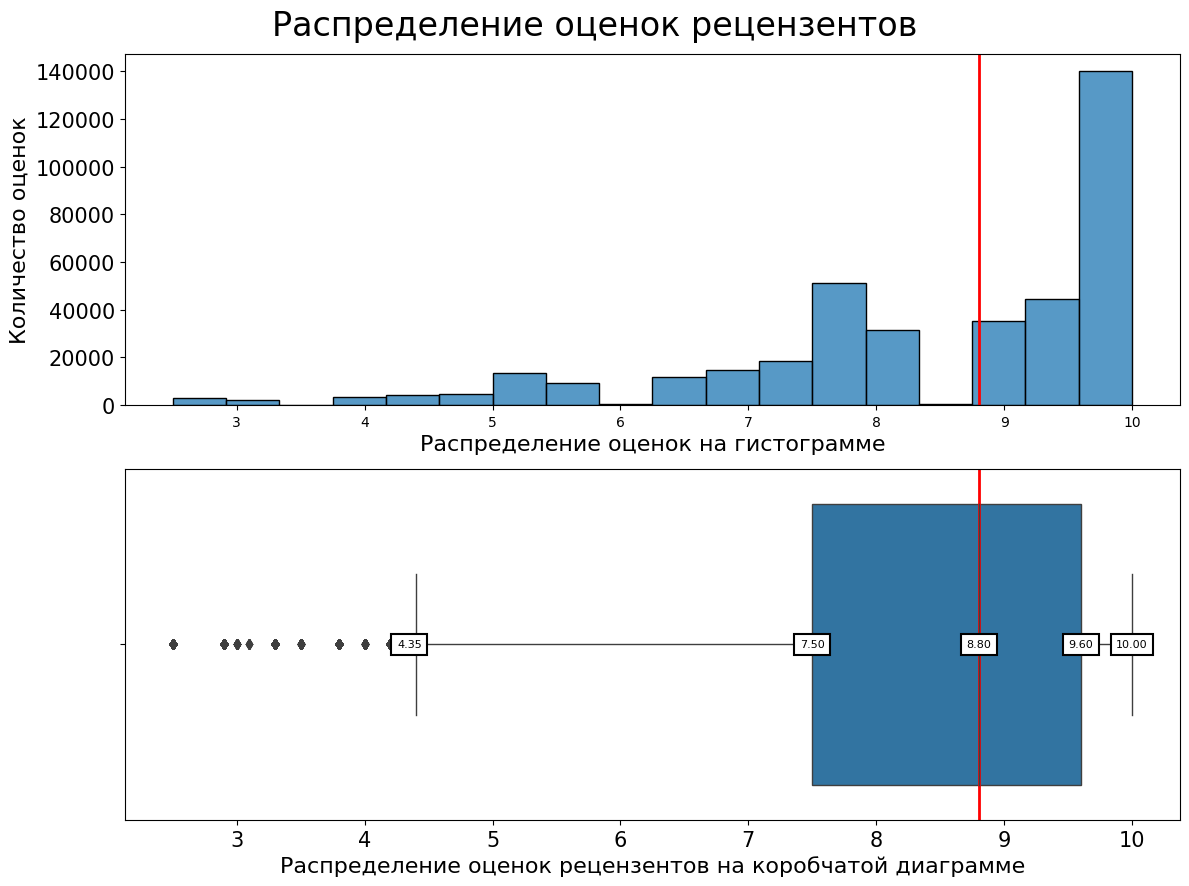

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

# построение гистограммы 
sns.histplot(
    data=hotels[hotels['sample'] == 1],
    x='reviewer_score',
    bins=18,
    ax=ax[0]
)

# построение коробчатой диаграммы
sns.boxplot(
    data=hotels[hotels['sample'] == 1],
    x='reviewer_score',
    # показать/скрыть усики по краям
    # showcaps=False,
    # толщина линий графика и усов
    linewidth=1,
    ax=ax[1]
)

# настройка и оформление гистограммы
# настройка подписи оси х
ax[0].set_xlabel('Распределение оценок на гистограмме', fontsize=16)
# настройка подписи оси у
ax[0].set_ylabel('Количество оценок',fontsize=16)
# настройка оформления значений оси у
ax[0].tick_params(axis='y', labelrotation=0, labelsize=15)
# добавление линии медианной оценкой отеля
ax[0].axvline(hotels[hotels['sample'] == 1]['reviewer_score'].median(), color='red', ls='-', lw=2)

# настройка и оформление коробчатой диаграммы
# настройка подписи оси х
ax[1].set_xlabel('Распределение оценок рецензентов на коробчатой диаграмме', fontsize=16)
# настройка оформления значений оси х
ax[1].tick_params(axis='x', labelsize=15)
# добавление медианной оценки отеля
ax[1].axvline(hotels[hotels['sample'] == 1]['reviewer_score'].median(), color='red', ls='-', lw=2)

# добавление квантилей и медианы на график для информативности
q1 = hotels[hotels['sample'] == 1]['reviewer_score'].quantile(0.25)
m = hotels[hotels['sample'] == 1]['reviewer_score'].median()
q3 = hotels[hotels['sample'] == 1]['reviewer_score'].quantile(0.75)
q5 = hotels[hotels['sample'] == 1]['reviewer_score'].quantile(1)
q0 = q1 - 1.5 * (q3 - q1)

# добавление значений квантилей и медианы на график (для просмотра всех настроек можно вызвать help(ax[1].text))
for value in (q0, q1, q3, m, q5):
    ax[1].text(
        # горизонтальное расположение значений на графике (равно выбранному значению)
        x=value,
        # вертильное расположение значений на графике
        y=0,
        # формат значений
        s=f"{value:.2f}",
        # горизонтальное расположение надписи значений относительно позиции на графике
        ha='center',
        # вертикальное расположение надписи значений относительно позиции на графике
        va='center',
        # размер шрифта значений
        size=8,
        # цвет шрифта значений
        color='black',
        # толщина шрифта значений
        fontweight='regular',
        # настройка прямоугольника, в котором вписаны значения
        bbox={
            # цвет фона
            'facecolor': 'white',
            # толщина границ
            'linewidth': 1.5
        }
    )

# настройка общей подписи графиков 
plt.suptitle('Распределение оценок рецензентов', size=24, weight=400)

fig.tight_layout();

Из гистограммы видно, что большинство пользователей ставили высокие оценки отелям, в которых останавливались. Больше всего отзывов содержит максимальный балл.

Рассмотрим датасет на наличие дубликатов. Узнаем, сколько всего дубликатов в датасете. Выведем эти значения:

In [16]:
hotels[hotels.duplicated()].shape[0]

336

Всего в датасете присутствуют 336 дубликатов, что составляет 0,065% от общего количества отзывов.

Давайте узнаем, какие отели имеют дубликаты в отзывах. Выведем названия отелей и их адреса:

In [17]:
hotels[hotels.duplicated()].groupby(['hotel_name', 'hotel_address'])['reviewer_score'].count().reset_index().set_index('hotel_name')

,hotel_address,reviewer_score
hotel_name,,
Copthorne Tara Hotel London Kensington,Scarsdale Place Kensington Kensington and Chel...,1
Fletcher Hotel Amsterdam,Schepenbergweg 50 Zuidoost 1105 AT Amsterdam N...,1
H tel Baume,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,50
H tel Concorde Montparnasse,40 Rue du Commandant Ren Mouchotte 14th arr 75...,235
Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,1
Hotel Le Sainte Beuve,9 Rue Sainte Beuve 6th arr 75006 Paris France,35
Mercure Paris Centre Tour Eiffel,20 Rue Jean Rey 15th arr 75015 Paris France,1
Park Plaza Vondelpark Amsterdam,Koninginneweg 34 36 Oud Zuid 1075 CZ Amsterdam...,1
Pertschy Palais Hotel,Habsburgergasse 5 01 Innere Stadt 1010 Vienna ...,1


Больше всего дубликатов отзывов имеет отель "*H tel Concorde Montparnasse*" в Париже.

# 2.2 Промежуточные выводы

Подведем итоги раздела. Что можно сказать о данных:
- практически во всех признаках отсутствовали пропуски. Выявленные пропуски для каждого отеля в признаках `lat` и `lng` удалось заполнить с помощью адреса отлеля в признаке `hotel_address`;
- в датасете присутствуют дубликаты. Так как удалять их нежелательно, далее создадим признак, в котором пометим, что отзыв является дубликатом;
- выбросов в целевом признаке `reviewer_score` не обнаружено;
- больше всего отзывы оставили жители Великобритании.

Пройдемся по признакам по порядку. Каую информацию можно из них получить:
- `hotel_address`: из признака адреса отеля можно извлечь название страны, в которой расположен отель, название города, название улицы, почтовый индекс;
- `review_data`: дата отзыва, можно извлечь год, квартал, месяц, день;
- `tags`: содержит в себе информацию о типе поездки, условиях и длительности проживания т.д.;
- `days_sience_review`: преобразуем в числовой признак - уберем *day* и оставим количество дней.
- `lat` и`lng`: с их помощью можно найти расстояние до центра города.

В целом, данные в порядке. Приступим к следующему шагу - проектирование признаков.

# 3. Проектирование признаков

Пришло время для создания новых признаков. Рассмотрим каждый из них по порядку.

## 3.1 Адрес отеля (*hotel_address*)

Рассмотрим первый признак - адрес отеля. Выведем для примера запись нескольких адресов на экран и познакомимся с ним получше.

In [18]:
for address in hotels.loc[0:5, 'hotel_address']:
    print(address)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy


В адресе указаны:
- номер дома;
- название улицы;
- название района;
- название города;
- возможно, почтовый индекс;
- название страны.

Что мы можем извлечь из этого индекса:
- название страны - поможет определить общее количество стран, в которых находятся отели, а также выяснить, влияет ли страна на оценку посетителей;
- название города - поможет узнать общее количество городов, позволит сгруппировать расположение отелей по городам, а также выяснить, влияет ли город на оценку посетителей;
- название района - позволить сгруппировать отели по районам в городе и узнать, влияет ли оценка посетителей от района расположения отеля;
- почтовый индекс - по почтовому индексу можно узнать адрес, расстояние до центра города, не будет лишним, может пригодиться.

Эту информацию можно легко получить с помощью библиотеки *geopy* по адресу отеля. Но так как *Kaggle* не позволяет использовать *geopy*, то придется разбираться с этим вручную

Узнаем общее количество стран, в которых расположены отели. Если вернуться чуть выше и посмотреть на запись адреса отеля, то можно заметить, что страна располагается в конце строки. Можно извлечь название страны, разбив строку по пробелам и взяв правый элемент. Но что делать со странами с названиями из нескольких слов, такими как *United Kingdom*, *Saudi Arabia*, *United Arab Emirates*? Давайте для начала возьмем два элемента справа:

In [19]:
hotels['hotel_address'].apply(lambda x: tuple(x.split()[-2:])).value_counts()

(United, Kingdom)           262301
(Barcelona, Spain)           60149
(Paris, France)              59928
(Amsterdam, Netherlands)     57214
(Vienna, Austria)            38939
(Milan, Italy)               37207
Name: hotel_address, dtype: int64

Как оказалось, стран, в которых расположены отели из датасета, всего 6:
- *United Kingdom*,
- *Spain*,
- *France*,
- *Netherlands*,
- *Austria*,
- *Italy*.

Создадим признак `country`, в котором будет содержаться название страны:

In [20]:
# создание признака country
hotels['country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' in x else x.split()[-1])

Выведеми уникальные значения признака `country`, заодно проверим, корректно ли прошло извлечение:

In [21]:
print(*hotels['country'].unique(), sep=', ')

United Kingdom, France, Netherlands, Italy, Austria, Spain


Все верно, уникальных стран всего 6.

При детальном рассмотрении адресов можно заметить, что для *United Kingdom* город расположен на пятом месте слева в строке. То есть, чтобы его извлечь, необходимо взять пятый элемент справа в разбитой по пробелам строке. Для остальных стран название города находится на второй позиции справа. Извлечем название города в признак `city`.

In [22]:
# создание признака city
hotels['city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

Узнаем, сколько городов представлено в нашем датасете: 

In [23]:
print(*hotels['city'].unique(), sep=', ')

London, Paris, Amsterdam, Milan, Vienna, Barcelona


Оказалось, что представлено шесть (6) столиц шести (6) стран.

Теперь рассмотрим почтовый индекс. Для *United Kingdom* и *Netherlands* индекс занимает 3 и 4 позиции в строке справа. Для остальных стран индекс указан на 3 позиции в строке справа. Извлечем индекс в признак `postcode`:

In [24]:
# создание признака postcode
hotels['postcode'] = hotels['hotel_address'].apply(lambda x: ' '.join(x.split()[-4:-2]) if x.split()[-1] in ('Kingdom', 'Netherlands') else x.split()[-3])

Выведем все названия городов, а также почтовых индексов для каждой страны:

In [25]:
data = hotels.groupby(['country', 'city', 'postcode']).count()

dct = dict()

for row in list(data.index):
    country, city, postcode = row
    dct.setdefault(country, dict())
    dct[country].setdefault(city, []).append(postcode)

for country, value in dct.items():
    for city, postcodes in value.items():
        print(f'Страна - {country}')
        print(f'Город - {city}')
        print('Почтовые индексы', end=' - ')
        print(*postcodes, sep='; ', end='\n\n')

Страна - Austria
Город - Vienna
Почтовые индексы - 1010; 1015; 1020; 1030; 1040; 1050; 1060; 1070; 1080; 1090; 1100; 1110; 1120; 1130; 1140; 1150; 1160; 1170; 1190; 1210; 1220; 1230

Страна - France
Город - Paris
Почтовые индексы - 75001; 75002; 75003; 75004; 75005; 75006; 75007; 75008; 75009; 75010; 75011; 75012; 75013; 75014; 75015; 75016; 75017; 75018; 75019; 75020; 75116; 92120; 92170

Страна - Italy
Город - Milan
Почтовые индексы - 20121; 20122; 20123; 20124; 20125; 20126; 20127; 20128; 20129; 20131; 20132; 20133; 20135; 20136; 20138; 20139; 20141; 20142; 20143; 20144; 20145; 20146; 20148; 20149; 20152; 20153; 20154; 20155; 20156; 20157; 20158; 20159; 20161; 20162

Страна - Netherlands
Город - Amsterdam
Почтовые индексы - 1011 AK; 1011 DK; 1011 KW; 1012 AD; 1012 CK; 1012 CP; 1012 EX; 1012 JS; 1012 KD; 1012 LG; 1012 LP; 1012 PV; 1012 RE; 1012 SJ; 1012 SZ; 1012 TM; 1012 VN; 1012 VX; 1012 WJ; 1013 MM; 1013 ZX; 1014 AG; 1015 CX; 1015 CZ; 1016 AZ; 1016 BJ; 1016 GB; 1016 GZ; 1017 BV; 10

Посмотрим, различаются ли оценки рецензентов в зависимости от города:

In [26]:
data_cities = hotels[hotels['sample'] == 1].groupby('city')['reviewer_score'].mean()
data_cities

city
Amsterdam    8.449214
Barcelona    8.553747
London       8.326884
Milan        8.355482
Paris        8.420587
Vienna       8.552642
Name: reviewer_score, dtype: float64

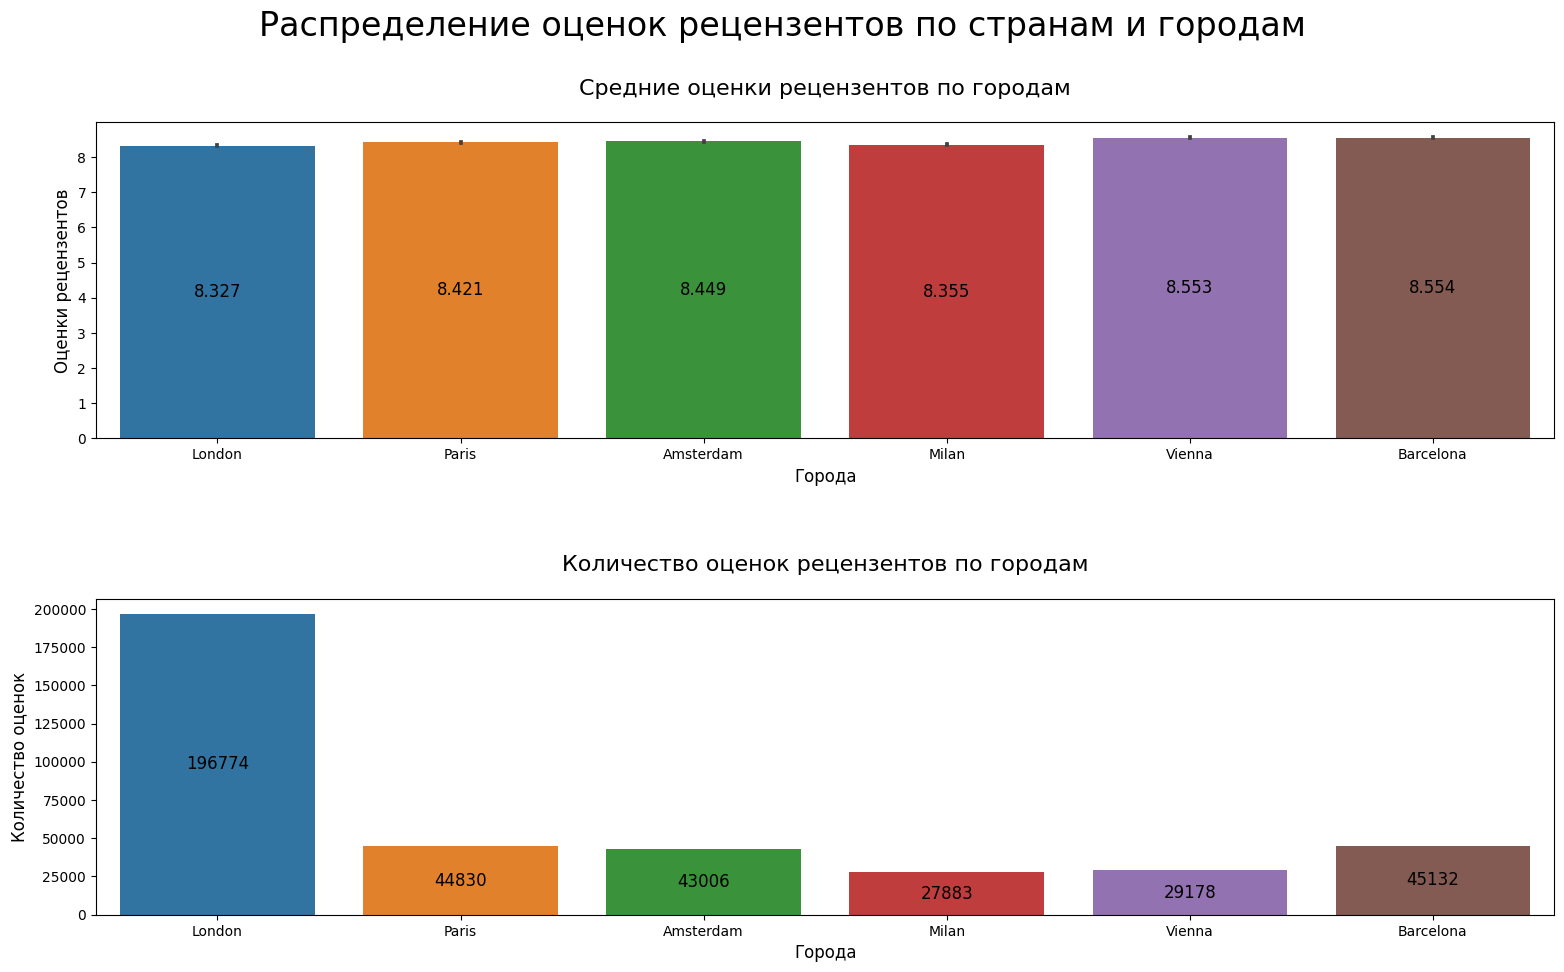

In [27]:
# посмтроение графиков
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))

# построение столбчатой диаграммы оценок по городам
sns.barplot(
    data=hotels[hotels['sample'] == 1],
    x='city',
    y='reviewer_score',
    ax=ax[0])

# построение столбчатой диаграммы количества отзывов по городам
sns.countplot(
    data=hotels[hotels['sample'] == 1],
    x='city',
    ax=ax[1])

# настройка первого графика
# настройка заголовка
ax[0].set_title('Средние оценки рецензентов по городам', size=16, pad=20)
# настройка подписи оси х
ax[0].set_xlabel('Города', fontsize=12)
# настройка подписи оси у
ax[0].set_ylabel('Оценки рецензентов', fontsize=12)
# добавление значений в каждом баре
ax[0].bar_label(ax[0].containers[0], label_type='center', fmt='%.3f', size=12)

# настройка второго графика
# настройка заголовка
ax[1].set_title('Количество оценок рецензентов по городам', size=16, pad=20)
# настройка подписи оси х
ax[1].set_xlabel('Города', fontsize=12)
# настройка подписи оси у
ax[1].set_ylabel('Количество оценок', fontsize=12)
# добавление значений в каждом баре
ax[1].bar_label(ax[1].containers[0], label_type='center', size=12)

# настройка заголовка полотна
fig.suptitle('Распределение оценок рецензентов по странам и городам', size=24, weight=400)

# дополнительные настройки (расстояние между графиками)
fig.tight_layout(pad=2, h_pad=5, w_pad=5);

Как можно заметить, оценки приблизительно одинаковые, однако подавляющее количество отзывов на отели в городе *London*. Скорее всего, признаки `country` и `city` практически не влияют на оценки. К тому же, они дают одинаковую информацию, так как в каждой стране представлено по одному городу.

## 3.2 Расстояние от центра города до отеля (*distance_to_center*)

Создадим признак `distance_to_center`, который будет показывать расстояние от отеля до центра города. Такая информация, возможно, пригодится, так как такой показатель часто присутствует в описании отелей на разных сервисах бронирования (например, в сервисах туроператоров часто указывается удаленность отеля от моря). 

Сделаем задуманное в два этапа:
1. Первым делом, с помощью библитотеки `geopy` определим координаты центра городов, в которых расположены отели. Создадим словарь, где ключом будет название города (будем использовать признак `city`, созданный ранее), а значением - кортеж с координатами широты и долготы (их получим с помощью библиотеки *Geopy*). Напомним, что городов всего 6.
2. Далее вычислим расстояние между центром города и отелем с помощью функции `geodesic` модуля `distance` библиотеки *Geopy*. Для этого напишем функцию, которая вычисляет расстояние от отеля до центра города. Функция будет принимать широту отеля, долготу отеля и город, в котором отель расположен, а возвращать расстояние в километрах.


С помощью следующего кода найдем координаты центров городов:

```
# определим координаты центров городов, в которых расположены отели

# создадим геолокатор
geolocator = Nominatim(user_agent="Petruhin_Andrey")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)

# создадим список с названиями городов
cities = list(hotels['city'].value_counts().index)

# создадим словарь: ключ - название города, значение - кортеж с координатами центра
city_center = dict()

for city in cities:
    location = geolocator.geocode(city)
    city_center[city] = (location.latitude, location.longitude)

# выведем результат
city_center
```

Код не всегда работает, *geopy* бывает капризничает, поэтому будем использовать данные, которые были получены ранее:

In [28]:
city_center = {'London': (51.507351, -0.127696),
 'Barcelona': (41.386378, 2.18676),
 'Paris': (48.856663, 2.351556),
 'Amsterdam': (52.373057, 4.892557),
 'Vienna': (48.206487, 16.36346),
 'Milan': (45.464183, 9.189595)}

In [29]:
# создадим функцию для вычисления расстояния между отелем и центром города 

def get_distance(lat:float, lng:float, center_coodinates:tuple)->float:
    '''
    Возвращает расстояние от центра города до отеля
    
            Параметры:
                    lat (float): значение широты
                    lng (float): значение долготы
                    
            Возвращаемое значение:
                    dist (float): значение расстояния в километрах
    '''
    return geodesic((lat, lng), center_coodinates).kilometers

Идея следующая:
- создим новый *dataframe*: сгруппируем основной по адресам отелей, городу, широте и долготе. Получится новый *dataframe*, в котором будут собраны уникальные значения адресов отелей, город, в котором они расположены, и их координаты;
- затем создадим новый признак `distance_to_center` в новом *dataframe* с помощью функции `get_distance`, который будет содержать расстояние от центра города до отеля;
- после этого оставим в новом *dataframe* признак `hotel_address` и `distance_to_center`, а потом объединим его с основным датасетом по признаку `hotel_address`. Поясню почему выбор пал на `hotel_address`. Была попытка объединить по названию отелей, но есть 3 отеля с одинаковым названием - *Hotel Regina*, расположенные в Барселоне, Милане и Вене, всего отзывов на эти три отеля 934 - см. ячейку ниже. Поэтому, при объединении по названию отеля добавляется дополнительно 1868 новых строк - к 934 оригинальным отзывам добавляется еще 934 х 2 = 1868 отзывов, так как для отеля *Hotel Regina* есть три варианта расстояния, потому что отели с таким названием находятся в трех городах. По итогам добавления получаем +1868 новых строк, которые дублируют друг друга по всем признакам за исключением `distance_to_center`. В этом случае корректнее использовать адрес отеля.

In [30]:
print('Отель Hotel Regina располагается в следующих городах:')
for hotel in list(hotels[hotels['hotel_name'] == 'Hotel Regina'].groupby('city').count().index):
    print(f' - {hotel}')
print('Суммарное количество отзывов на отели Hotel Regina -', hotels[hotels['hotel_name'] == 'Hotel Regina'].shape[0])

Отель Hotel Regina располагается в следующих городах:
 - Barcelona
 - Milan
 - Vienna
Суммарное количество отзывов на отели Hotel Regina - 934


Итак, приступим.

In [31]:
# сгруппируем таблицу по адресу отеля, городу, широте и долготе, переназначим индексы и оставим необходимые признаки
hotels_coordinates = hotels.groupby(['hotel_address', 'city', 'lat', 'lng']).count().reset_index()[['hotel_address', 'city', 'lat', 'lng']]

# выведем полученный dataframe
hotels_coordinates

,hotel_address,city,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968
1,1 15 Templeton Place Earl s Court Kensington a...,London,51.491888,-0.194971
2,1 2 Serjeant s Inn Fleet Street City of London...,London,51.513734,-0.108751
3,1 3 Queens Garden Westminster Borough London W...,London,51.514218,-0.180903
4,1 3 Rue d Argentine 16th arr 75116 Paris France,Paris,48.874348,2.289733
...,...,...,...,...
1488,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,Vienna,48.193523,16.366915
1489,Wildpretmarkt 5 01 Innere Stadt 1010 Vienna Au...,Vienna,48.210447,16.371578
1490,Wilton Place Knightsbridge Westminster Borough...,London,51.502091,-0.157779
1491,Wrights Lane Kensington and Chelsea London W8 ...,London,51.499981,-0.192879


In [32]:
# создадим новый признак distance_to_center с помощью функции get_distance
hotels_coordinates['distance_to_center'] = hotels_coordinates.apply(lambda x: get_distance(x.lat, x.lng, city_center[x.city]), axis=1)

# выведем обновленный dataframe
hotels_coordinates

,hotel_address,city,lat,lng,distance_to_center
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,2.114663
1,1 15 Templeton Place Earl s Court Kensington a...,London,51.491888,-0.194971,4.978336
2,1 2 Serjeant s Inn Fleet Street City of London...,London,51.513734,-0.108751,1.494686
3,1 3 Queens Garden Westminster Borough London W...,London,51.514218,-0.180903,3.772056
4,1 3 Rue d Argentine 16th arr 75116 Paris France,Paris,48.874348,2.289733,4.943862
...,...,...,...,...,...
1488,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,Vienna,48.193523,16.366915,1.464161
1489,Wildpretmarkt 5 01 Innere Stadt 1010 Vienna Au...,Vienna,48.210447,16.371578,0.746946
1490,Wilton Place Knightsbridge Westminster Borough...,London,51.502091,-0.157779,2.169223
1491,Wrights Lane Kensington and Chelsea London W8 ...,London,51.499981,-0.192879,4.599662


In [33]:
# оставим признаки hotel_address и distance_to_center
hotels_distance = hotels_coordinates.loc[:, ['hotel_address', 'distance_to_center']]

# выведем обновленный dataframe
hotels_distance

,hotel_address,distance_to_center
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,2.114663
1,1 15 Templeton Place Earl s Court Kensington a...,4.978336
2,1 2 Serjeant s Inn Fleet Street City of London...,1.494686
3,1 3 Queens Garden Westminster Borough London W...,3.772056
4,1 3 Rue d Argentine 16th arr 75116 Paris France,4.943862
...,...,...
1488,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,1.464161
1489,Wildpretmarkt 5 01 Innere Stadt 1010 Vienna Au...,0.746946
1490,Wilton Place Knightsbridge Westminster Borough...,2.169223
1491,Wrights Lane Kensington and Chelsea London W8 ...,4.599662


In [34]:
# объединим с помощью функции merge 
hotels = hotels.merge(hotels_distance, on='hotel_address', how='left')

# проверим, что не добавлось лишних строк
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Модель плохо работает с числами с плавающей точкой, поэтому сделаем признак `distence_category` категориальным - заменим расстояние на промежутки:
- менее 1 км *less than km* - категория 1;
- от 1 до 2 км *from 1 to 2 km* - категория 2;
- от 2 до 5 км *from 2 to 5 km* - категория 3;
- от 5 до 10 км *from 5 to 10 km* - категория 4;
- более 10 км *more than 10 km* - категория 5.

Создадим функцию `get_distance_category` для определения категории расстояния отеля от центра города.

In [35]:
# создание функции для категоризации расстояния от центра города до отеля
def get_distance_category(distance: float)-> int:
    '''
    Возвращает номер категории в зависимости расстояния от центра города до отеля
    
            Параметры:
                    distance (float): значение расстояния
                    
            Возвращаемое значение:
                    *Number of category* (int): номер категории, которая соответствует заданному расстоянию
    '''
    if 0 < distance < 1:
        return 1
    elif 1 <= distance <= 2:
        return 2
    elif 2 < distance <= 5:
        return 3
    elif 5 < distance <= 10:
        return 4
    return 5

In [36]:
# создание признака distance_category
hotels['distance_category'] = hotels['distance_to_center'].apply(get_distance_category)

Посмотрим количество отелей для каждой категории дистанции до центра города и есть ли различия в оценке таких отелей.

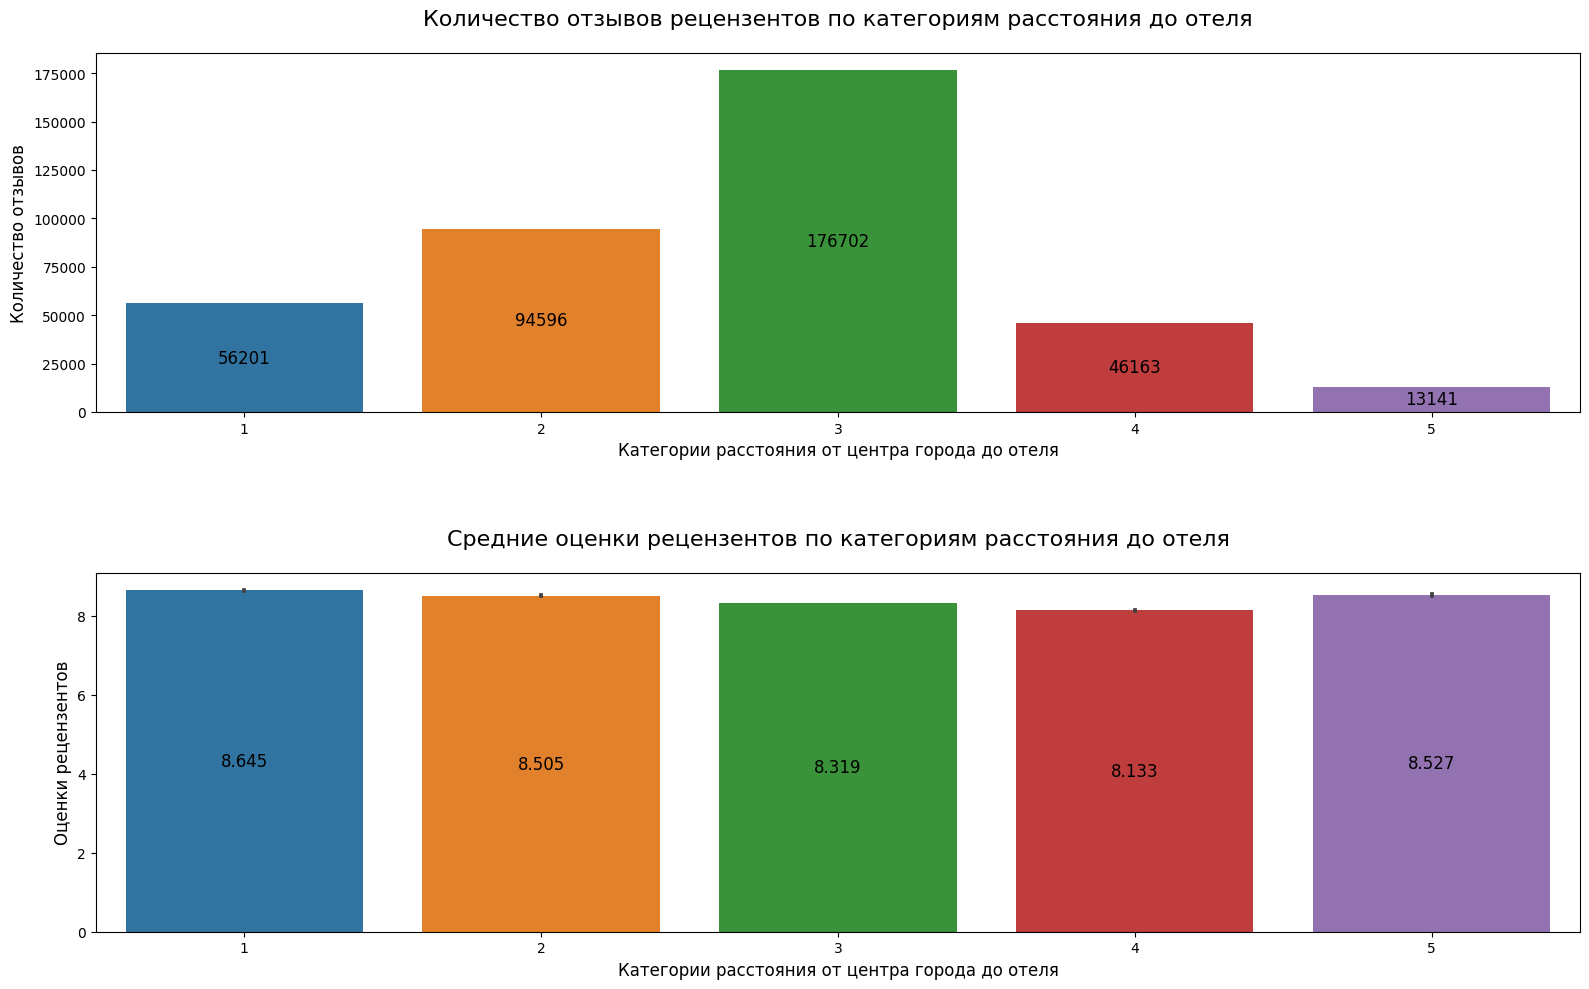

In [37]:
# создание полотна для двух графиков
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))

# построение столбчатой количественной диаграммы
sns.countplot(
    data=hotels[hotels['sample'] == 1],
    x='distance_category',
    ax=ax[0]
)

# построение столбчатой диаграммы со средними оценками
sns.barplot(
    data=hotels[hotels['sample'] == 1],
    x='distance_category',
    y='reviewer_score',
    ax=ax[1]
)

# настройка подписи первого графика
# настройка заголовка
ax[0].set_title('Количество отзывов рецензентов по категориям расстояния до отеля', size=16, pad=20)
# настройка подписи оси х
ax[0].set_xlabel('Категории расстояния от центра города до отеля', fontsize=12)
# настройка подписи оси у
ax[0].set_ylabel('Количество отзывов', fontsize=12)
# добавление значений в каждом баре
ax[0].bar_label(ax[0].containers[0], label_type='center', size=12)

# настройка подписи второго графика
# настройка заголовка
ax[1].set_title('Средние оценки рецензентов по категориям расстояния до отеля', size=16, pad=20)
# настройка подписи оси х
ax[1].set_xlabel('Категории расстояния от центра города до отеля', fontsize=12)
# настройка подписи оси у
ax[1].set_ylabel('Оценки рецензентов', fontsize=12)
# добавление значений в каждом баре
ax[1].bar_label(ax[1].containers[0], label_type='center', fmt='%.3f', size=12)

fig.tight_layout(h_pad=5);

По первому графику видно, что больше всего отзывов на отели, которые расположены на расстоянии от 2 до 5 км от центра города. При этом оценки мало отличаются от расстояния, что видно на втором графике. Похоже, что расстояние от центра города до отеля не сильно вляет на оценку.

## 3.3 Дата размещения отзыва (*review_date*)

Поработаем теперь с датами размещения отзывов. Что можем из нее извлечь:
- день;
- месяц;
- квартал;
- год.

Преобразуем признак *review_date* из *object* в *datetime*.

In [38]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=False)

Создадим новые признаки *day*, *day_of_week*, *month*, *year*, а также *period* (возьмем по месяцам) для оценки динамики изменения оценок рецензентов, возможно получится увидеть *сезонные* закономерности в оценках.

In [39]:
hotels['day'] = hotels['review_date'].dt.day
hotels['day_of_week'] = hotels['review_date'].dt.day_of_week
hotels['month']= hotels['review_date'].dt.month
hotels['year'] = hotels['review_date'].dt.year
hotels['period'] = hotels['review_date'].dt.to_period('M')

Построим столбатые диаграммы и оценим результаты:

In [40]:
period_count = hotels[hotels['sample'] == 1].groupby('period')['reviewer_score'].count()
period_mean = hotels[hotels['sample'] == 1].groupby('period')['reviewer_score'].mean()

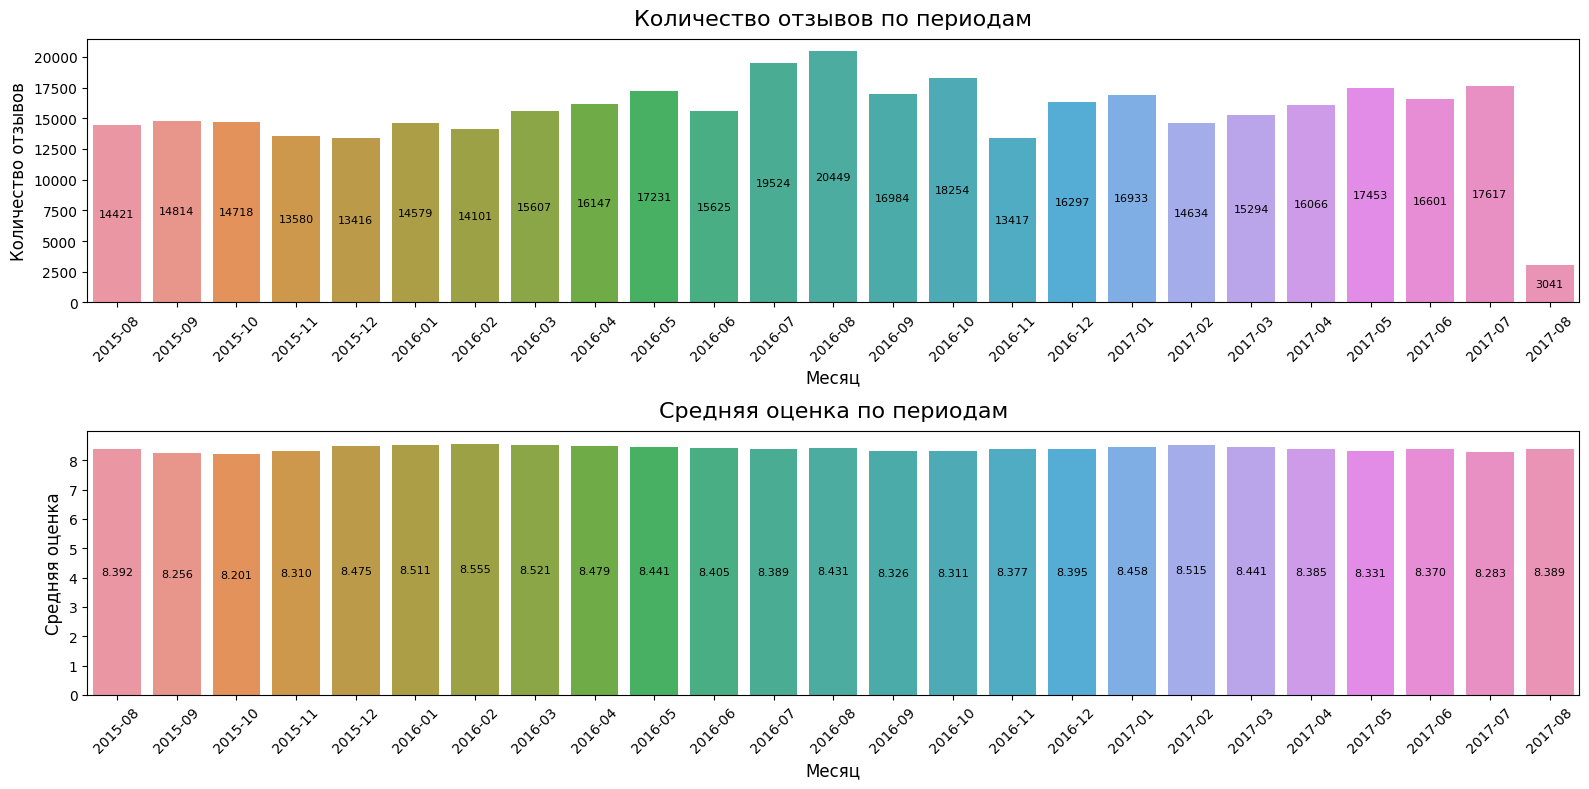

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

sns.barplot(
    x=period_count.index,
    y=period_count,
    ax=ax[0]
)

sns.barplot(
    x=period_mean.index,
    y=period_mean,
    ax=ax[1]
)

# настройка подписи первого графика
ax[0].set_title('Количество отзывов по периодам', size=16, pad=10)
# настройка подписи оси х
ax[0].set_xlabel('Месяц', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)
# настройка подписи оси у
ax[0].set_ylabel('Количество отзывов', fontsize=12)
# добавление значений в каждом баре
ax[0].bar_label(ax[0].containers[0], label_type='center', size=8)

# настройка подписи второго графика
ax[1].set_title('Средняя оценка по периодам', size=16, pad=10)
# настройка подписи оси х
ax[1].set_xlabel('Месяц', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)
# настройка подписи оси у
ax[1].set_ylabel('Средняя оценка', fontsize=12)
# добавление значений в каждом баре
ax[1].bar_label(ax[1].containers[0], label_type='center', size=8, fmt='%.3f')

fig.tight_layout();

На первой диаграмме можно заметить, что количество отзывов растет летом и уменьшается зимой. Возможно, влияет *сезон отпусков* - многие берут отпуск летом. На второй диаграмме видно, что средние оценки практически не отличаются. Можно предположить, что на оценку период написания отзыва не влияет.

## 3.4 Количество дней между датой проверки и датой очистки (*days_since_review*)

Так как модель работает только с числами, преобразуем признак *days_since_review* из *object* в *int*. Уберем из столбца лишнее и оставим только количество дней.

In [42]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

## 3.5 Национальность рецензента (*reviewer_nationality*)

Посмотрим на национальности рецензентов. Создадим признак `native`, который покажет, является ли рецензент коренным жителей или иностранным туристом. **native** - коренной житель, **tourist** - иностранец, турист.

In [43]:
hotels['native'] = hotels.apply(lambda x: 'native' if x['country'] == x['reviewer_nationality'].strip() else 'tourist', axis=1)

In [44]:
hotels['native'].value_counts(normalize=True)*100

tourist    65.408211
native     34.591789
Name: native, dtype: float64

Практически 35% рецензентов были коренными жителями. Посмотрим какие оценки ставят туристы и коренные жители.

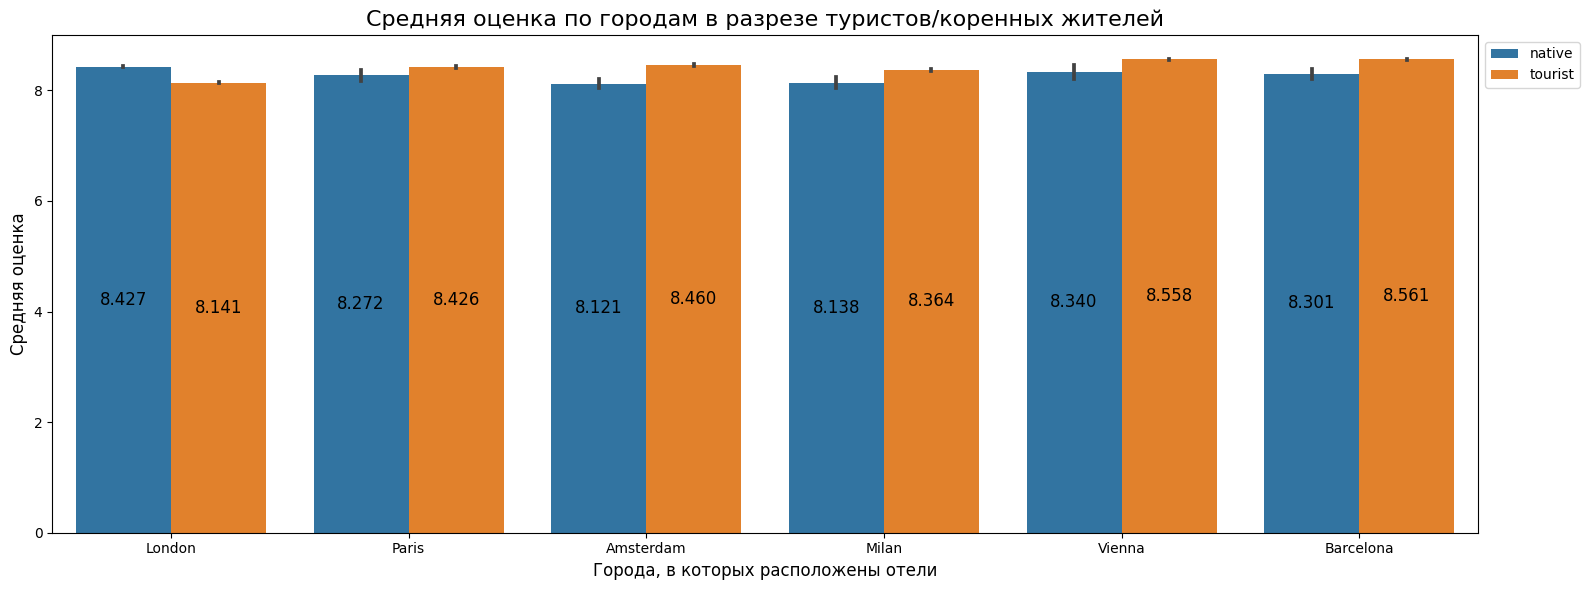

In [45]:
# построение графика зависимости оценки от признака native
fig = plt.figure(figsize=(16, 6))

# столбчатая диаграмма средних оценок местных жителей по городам
barplot = sns.barplot(
    data=hotels[hotels['sample'] == 1],
    x='city',
    y='reviewer_score',
    hue='native'
)

# настройка второго графика
# настройка заголовка
barplot.set_title('Средняя оценка по городам в разрезе туристов/коренных жителей', size=16)
# настройка подписи оси х
barplot.set_xlabel('Города, в которых расположены отели', fontsize=12)
# настройка подписи оси у
barplot.set_ylabel('Средняя оценка', fontsize=12)
# добавление значений в каждом баре
barplot.bar_label(barplot.containers[0], label_type='center', size=12, fmt='%.3f')
barplot.bar_label(barplot.containers[1], label_type='center', size=12, fmt='%.3f')

# настройка легенды
barplot.legend(loc='upper left', bbox_to_anchor=(1, 1))
barplot.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(h_pad=5);

Как мы видим, оценки у местных жителей и туристов не на много отличаются во всех городах, из чего можно сделать вывод, что это не влияет на оценку.

## 3.6 Работа с тегами (*tags*)

Рассмотрим признак `tags`. Выведем для примера одну запись из этого столбца:

In [46]:
hotels.loc[0, 'tags']

"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"

Можно увидеть, что признак содержит строку с тегами, которые оставляют пользователи в отзывах. Со строкой работать не очень удобно, попробуем сделать из нее список тегов. Для этого необходимо убрать кавычки ', квадратные скобки [] и пробелы, а затем разбить строку по запятой. В очистке строки от лишних символов нам помогут регулярные выражения.

In [47]:
# регулярное выражение находит все совпадения группы - той части, что в скобках; символы до и после группы не учитываются
# преобразование строки тегов в кортеж тегов с помощью регулярного выражения
hotels['tags'] = hotels['tags'].apply(lambda x: tuple(re.findall(r'\' ?(.+?) ?\'', x)))

Выведем одну запись признака `tags` и посмотрим что получилось:

In [48]:
tags = hotels.loc[0, 'tags']

print(f'Теперь теги выглядят так: {tags}')
print(f'Тип данных в ячейке с тегами: {type(tags)}')

Теперь теги выглядят так: ('Leisure trip', 'Couple', 'Studio Suite', 'Stayed 2 nights', 'Submitted from a mobile device')
Тип данных в ячейке с тегами: <class 'tuple'>


Как видим - преобразование прошло успешно, строка преобразовалась в кортеж.

Соберем все теги в один список и узнаем, какие из них самые популярные. В этом нам поможет счетчик `Counter`.

In [49]:
# создадим пустой список и заполним его всеми тегами из датасета
tags_list = list()

# заполним список тегами из датасета
hotels['tags'].apply(lambda x: tags_list.extend(list(x)))

# создадим счетчик tags_counter
tags_counter = Counter(tags_list)

# выведем топ 25 самых популярных тегов
display(tags_counter.most_common(25))

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670)]

В топе оказались:
- Поездка на отдых (*Leisure trip*);
- Отправлено с мобильного устройства (*Submitted from a mobile device*);
- Пара (*Couple*);
- Пребывание на 1 ночь (*Stayed 1 night*);
- Остановка на 2 ночи (*Stayed 1 night*);
- Одиночный путешественник (*Solo traveler*);
- Остановка на 3 ночи (*Stayed 3 nights*);
- Командировка (*Business trip*);
- Компания (*Group*);
- Семья с маленькими детьми (*Family with young children*);
- Остановка на 4 ночи (*Stayed 4 nights*);
- Двухместный номер с одной кроватью (*Double Room*);
- Стандартный двухместный номер с одной кроватью (*Standard Double Room*);
- Улучшенный двухместный номер с одной кроватью (*Superior Double Room*);
- Семья со взрослыми детьми (*Family with older children*);
- Двухместный номер делюкс (*Deluxe Double Room*);
- Двухместный номер с одной кроватью или с двумя отдельными кроватями (*Double or Twin Room*);
- Остановка на 5 ночей (*Stayed 5 nights*);
- Стандартный двухместный номер с одной кроватью или двумя отдельными кроватями (*Standard Double or Twin Room*);
- Классический двухместный номер с одной кроватью (*Classic Double Room*);
- Улучшенный двухместный номер с одной кроватью или двумя отдельными кроватями (*Superior Double or Twin Room*);
- Две комнаты (*2 rooms*);
- Остановка на 6 ночей (*Stayed 6 nights*);
- Стандартный двухместный номер с двумя отдельными кроватями (*Standard Twin Room*);
- Одноместный номер (*Single Room*).

### 3.6.1 Колчество тегов (*tags_count*)

Создадим признак, который будет показывать количество тегов - `tags_count`.

In [50]:
hotels['tags_count'] = hotels['tags'].apply(lambda x: len(x))

Посмотрим, что получилось:

In [51]:
hotels['tags_count'].value_counts()

5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: tags_count, dtype: int64

Количество тегов варьируется от 1 до 6. Больше всего отзывов с 4 и 5 тегами. Рассмотрим зависимость оценок от количества тегов.

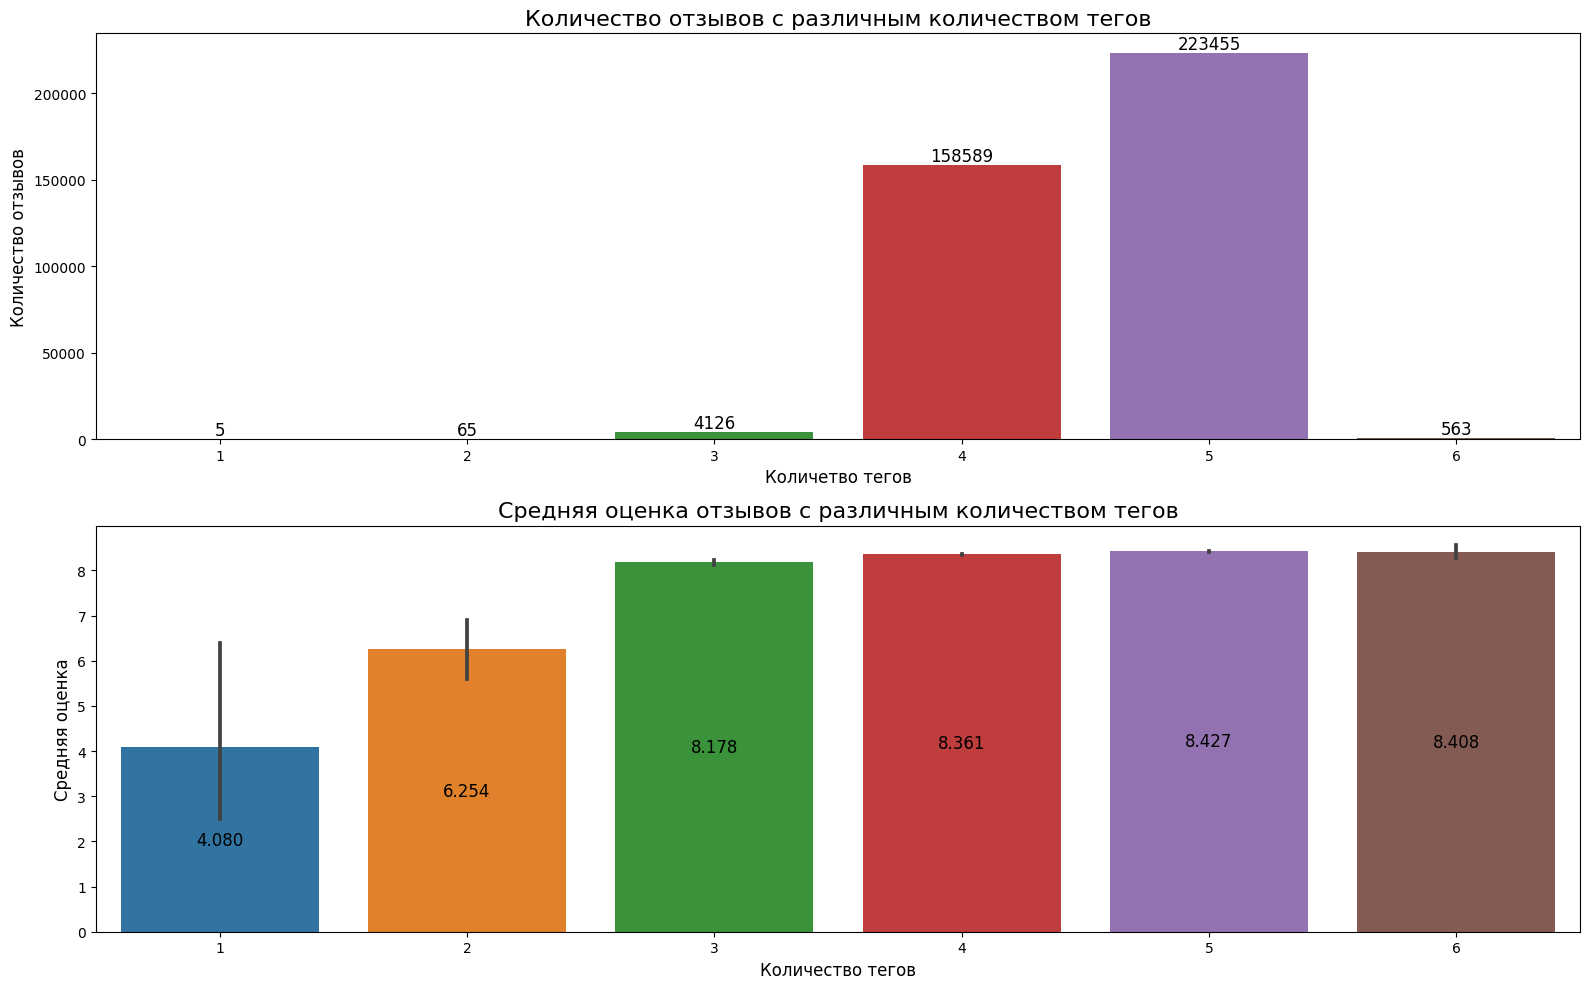

In [52]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))

sns.countplot(
    data=hotels[hotels['sample'] == 1],
    x='tags_count',
    ax=ax[0]
)

sns.barplot(
    data=hotels[hotels['sample'] == 1],
    x='tags_count',
    y='reviewer_score',
    ax=ax[1]
)

# настройка первого графика
# настройка заголовка
ax[0].set_title('Количество отзывов с различным количеством тегов', size=16)
# настройка подписи оси х
ax[0].set_xlabel('Количетво тегов', fontsize=12)
# настройка подписи оси у
ax[0].set_ylabel('Количество отзывов', fontsize=12)
# добавление значений в каждом баре
ax[0].bar_label(ax[0].containers[0], label_type='edge', size=12)

# настройка второго графика
# настройка заголовка
ax[1].set_title('Средняя оценка отзывов с различным количеством тегов', size=16)
# настройка подписи оси х
ax[1].set_xlabel('Количество тегов', fontsize=12)
# настройка подписи оси у
ax[1].set_ylabel('Средняя оценка', fontsize=12)
# добавление значений в каждом баре
ax[1].bar_label(ax[1].containers[0], label_type='center', size=12, fmt='%.3f')

fig.tight_layout();

Самые многочисленные отзывы имеют 4 и 5 тега. При этом самые низкие средние оценки у отзывов с 1 и 2 тегами, для остальных оценки не сильно отличаются друг от друга.

### 3.6.2 Способ отправки отзыва (*submitted_mobile*)

Среди тегов есть тег *Submitted from a mobile device* - отправлено с мобильного устройства. Создадим признак `submitted_mobile`, который покажет, отправлялся ли отзыв с мобильного устройства или нет.

In [53]:
hotels['submitted_mobile'] = hotels['tags'].apply(lambda x: 'yes' if 'Submitted from a mobile device' in x else 'no')

Посмотрим, сколько отзывов оставлено через мобильное устройство:

In [54]:
hotels['submitted_mobile'].value_counts(normalize=True)*100

yes    59.650443
no     40.349557
Name: submitted_mobile, dtype: float64

Практически 60% отзывов отправлено с мобильного устройства. Посмотрим как это влияет на оценки рецензентов:

In [55]:
hotels[hotels['sample'] == 1].groupby('submitted_mobile')['reviewer_score'].agg(['count', 'mean'])

,count,mean
submitted_mobile,,
no,156025,8.367432
yes,230778,8.416833


С мобильного устройства отправлено почти в полтора раза больше отзывов, чем другими способами. Однако, оценки практически не отличаются.

### 3.6.3 Длительность проживания в отеле (*duration*)

В тегах есть тег с длительностью проживания. Соберем все возможные варианты:

In [56]:
# количество вариантов длительности отдыха
stayed = [tag for tag in list(tags_counter) if 'stayed' in tag.lower()]
stayed.sort(key=lambda x: int(x.split()[1]))

display(stayed)

['Stayed 1 night',
 'Stayed 2 nights',
 'Stayed 3 nights',
 'Stayed 4 nights',
 'Stayed 5 nights',
 'Stayed 6 nights',
 'Stayed 7 nights',
 'Stayed 8 nights',
 'Stayed 9 nights',
 'Stayed 10 nights',
 'Stayed 11 nights',
 'Stayed 12 nights',
 'Stayed 13 nights',
 'Stayed 14 nights',
 'Stayed 15 nights',
 'Stayed 16 nights',
 'Stayed 17 nights',
 'Stayed 18 nights',
 'Stayed 19 nights',
 'Stayed 20 nights',
 'Stayed 21 nights',
 'Stayed 22 nights',
 'Stayed 23 nights',
 'Stayed 24 nights',
 'Stayed 25 nights',
 'Stayed 26 nights',
 'Stayed 27 nights',
 'Stayed 28 nights',
 'Stayed 29 nights',
 'Stayed 30 nights',
 'Stayed 31 nights']

Создадим признак *duration* - длительность проживания в отеле. Возможно, длительность проживания влияет на оценку пользователей: чем дольше ты живешь в номере, тем больше недостатков или достоинств замечаешь.

In [57]:
# создадим функцию получения длительности проживания
# получает список тегов, находит тег с длительностью проживания 
# и возвращает количество дней

def get_duration(tags):
    '''
    Возвращает количество ночей, длительность остановки рецензента
    
            Параметры:
                    tags (tuple): теги из отзыва
                    
            Возвращаемое значение:
                    (количество ночей) (int): количество ночей
    '''
    for tag in tags:
        if 'stayed' in tag.lower():
            return int(tag.split()[1])
    return 0

In [58]:
# создание признака duration

hotels['duration'] = hotels['tags'].apply(get_duration)

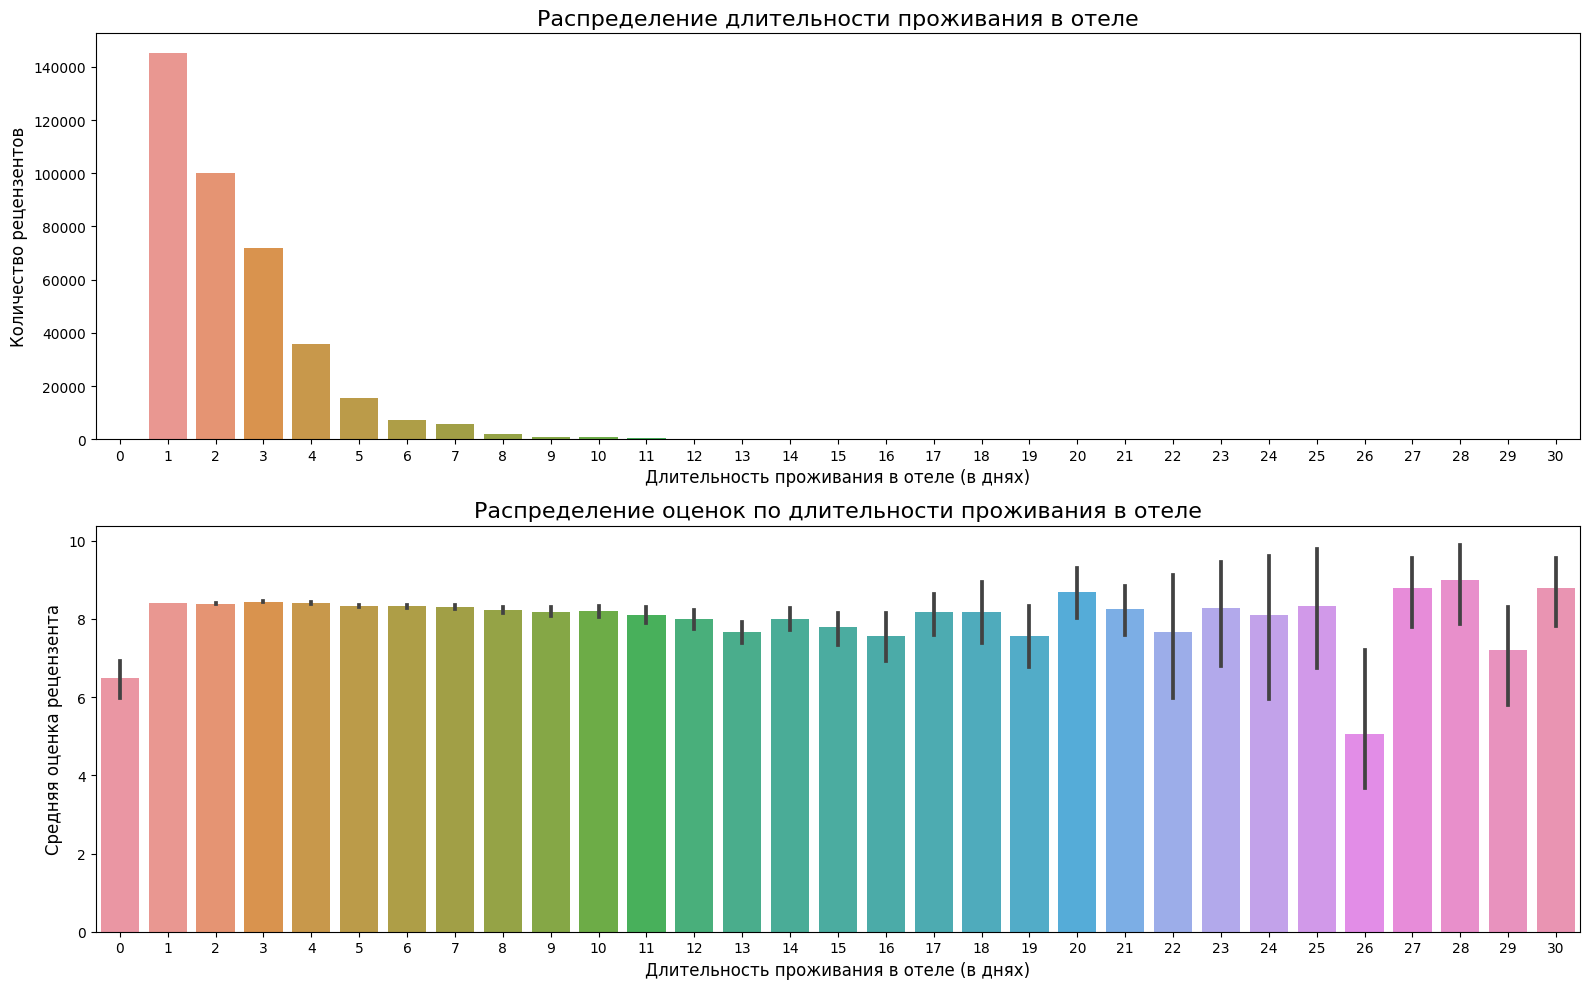

In [59]:
# визуализируем средние оценки пользователей в зависимости от количества дней проживания
# и какое количество пользователей на сколько дней оставалось
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

sns.countplot(
    data=hotels[hotels['sample'] == 1],
    x='duration',
    ax=ax[0]
)

sns.barplot(
    data=hotels[hotels['sample'] == 1],
    x='duration',
    y='reviewer_score',
    ax=ax[1]
)

# настройка первого графика
# настройка заголовка
ax[0].set_title('Распределение длительности проживания в отеле', size=16)
# настройка подписи оси х
ax[0].set_xlabel('Длительность проживания в отеле (в днях)', fontsize=12)
# настройка подписи оси у
ax[0].set_ylabel('Количество рецензентов', fontsize=12)

# настройка второго графика
# настройка заголовка
ax[1].set_title('Распределение оценок по длительности проживания в отеле', size=16)
# настройка подписи оси х
ax[1].set_xlabel('Длительность проживания в отеле (в днях)', fontsize=12)
# настройка подписи оси у
ax[1].set_ylabel('Средняя оценка рецензента', fontsize=12)

plt.tight_layout();

Больше всего посетителей останавливалось от 1 до 7 дней. Как можно увидеть, оценки не сильно зависят от количества дней, проведенных в отеле, за исключением 0 дней, 26 дней и 29 дней. Но количество отзывов рецензентов, которые провели в отелях указанные промежутки, крайне мало.

### 3.6.4 Группы туристов (соло, пара, компания, семья)

Узнаем, сколько видов каждой группы существует в тегах. Создадим список с тегами для семьи в различных вариантах `family_list`, список для пар `couple_list`, список для групп `group_list` и для соло туристов `solo_list`.

In [60]:
solo_list = [tag for tag in list(tags_counter) if 'solo' in tag.lower()]
couple_list = [tag for tag in list(tags_counter) if 'couple' in tag.lower()]
group_list = [tag for tag in list(tags_counter) if 'group' in tag.lower() or 'friends' in tag.lower()]
family_list = [tag for tag in list(tags_counter) if 'family' in tag.lower() and 'children' in tag.lower()]

In [61]:
print('Теги с соло:', *solo_list, sep='\n- ', end='\n\n')
print('Теги с парами:', *couple_list, sep='\n- ', end='\n\n')
print('Теги с группами:', *group_list, sep='\n- ', end='\n\n')
print('Теги с семьей:', *family_list, sep='\n- ')

Теги с соло:
- Solo traveler
- Solo Room

Теги с парами:
- Couple

Теги с группами:
- Group
- Travelers with friends
- Suite Family and Friends

Теги с семьей:
- Family with young children
- Family with older children
- Executive Family Room 2 Adults and 2 Children
- Family Room 2 Adults 2 Children
- Family Suite 2 Adults 2 Children
- Two Bedroom Family Joining Suite with Mobile Phone 2 adults 3 children
- Family Room 2 Adults 2 Children with Access to Nagomi Health
- Family Premium Room 2 Adults 2 Children
- Family Executive Room 2 Adults 2 Children
- Superior Family Room 2 Adults 2 Children
- Family Room 2 Adults 1 Children
- Family Room 2 Adults 3 Children
- Family Apartment 2 Adults 2 Children
- Family Room with View 2 Adults 2 Children
- Deluxe Family Room 2 Adults 2 Children
- Suite Family Room 2 Adults 2 Children


Удалось узнать, что рецензенты путешествовали в следующих компаниях:
- *Solo traveler* ;
- *Couple* ;
- *Group*;
- *Travelers with friends* ;
- *Family with young children*;
- *Family with older children* ;
- *Unknown*

Создадим признак `travel_company`, в котором укажем в какой компании путешествовал рецензент. Для этого создадим функцию `get_travel_company`, которая будет принимать список тегов в отзыве и возвращать тип компании, в которой путешествовал рецензент.

In [62]:
def get_travel_company(tags):
    '''
    Возвращает тип группы, в которой путешествуют рецензенты
    
            Параметры:
                    tags (tuple): теги из отзыва
                    
            Возвращаемое значение:
                    (тип компании) (str): тип компании, в которой путешествуют рецензенты
    '''
    if 'Solo traveler' in tags:
        return 'Solo traveler'
    elif 'Couple' in tags:
        return 'Couple'
    elif 'Group' in tags:
        return 'Group'
    elif 'Travelers with friends' in tags:
        return 'Travelers with friends'
    elif 'Family with young children' in tags:
        return 'Family with young children'
    elif 'Family with older children' in tags:
        return 'Family with older children'
    else:
        return 'Unknown'

In [63]:
# создадим признак travel_company
hotels['travel_company'] = hotels['tags'].apply(get_travel_company)

In [64]:
# количестве отзывов каждой группы
hotels['travel_company'].value_counts()

Couple                        252294
Solo traveler                 108545
Group                          65392
Family with young children     61015
Family with older children     26349
Travelers with friends          2143
Name: travel_company, dtype: int64

In [65]:
travel_company = hotels[hotels['sample'] == 1].groupby('travel_company')['reviewer_score'].agg(['count', 'mean'])
travel_company

,count,mean
travel_company,,
Couple,189212,8.513963
Family with older children,19802,8.440658
Family with young children,45836,8.304660
Group,49088,8.447454
Solo traveler,81235,8.132807
Travelers with friends,1630,8.511104


Можем увидеть, что больше всего отзывов оставили пары. Однако среди разных компаний сильной разницы в средней оценке не наблюдается.

### 3.6.5 Тип путешествия (*trip_type*)

В списке тегов есть теги, указывающие на тип поездки
- *business trip* - командировка;
- *leisure trip* - поездка на отдых.

Проверим, есть ли еще теги, связанные с поездками. Обратимся к ранее созданному контейнеру тегов `tags_counter`:

In [66]:
trip = [tag for tag in list(tags_counter) if 'trip' in tag.lower().split()]
trip

['Leisure trip', 'Business trip']

Выясним, сколько отзывов без указания типа поездки:

In [67]:
counter = 0
for tag in hotels['tags']:
    if 'Leisure trip' in tag or 'Business trip' in tag:
        continue 
    counter += 1

print(f'Без указания типа поездки имеется {counter} отзыв(ов)')

Без указания типа поездки имеется 15021 отзыв(ов)


Создадим признак `trip_type`, в котором укажем, какой тип поезки был у рецензента. Создадим функцию `get_trip_type`, которая будет принимать список тегов и возврать тип поездки.

Добавим следующие значения:
- *Leisure trip* - поездка на отдых;
- *Business trip* - командировка.

Если ни один тип поездки из двух вышеперечисленных не был найден, то попробуем угадать и заполнить по другим тегам: 
- в командировку обычно едет один человек, так что если в списке тегов есть тег *Solo traveler*, будем считать, что этот человек ездил в командировку;
- для остальных случаев будем считать, что была поездка на отдых.

In [68]:
def get_trip_type(tags):
    '''
    Возвращает тип путешествия рецензента: leisure trip (поездка на отдых) или businesss trip (командировка)
    
            Параметры:
                    tags (tuple): теги из отзыва
                    
            Возвращаемое значение:
                    (тип путешествия) (int): тип путешествия рецезента
    '''
    if 'Leisure trip' in tags:
        return 'Leisure trip'
    elif 'Business trip' in tags:
        return 'Business trip'
    else:
        if 'Solo traveler' in tags:
            return 'Business trip'
        else:
            return 'Leisure trip'

In [69]:
hotels['trip_type'] = hotels['tags'].apply(get_trip_type)

In [70]:
hotels['trip_type'].value_counts(normalize=True)*100

Leisure trip     83.080169
Business trip    16.919831
Name: trip_type, dtype: float64

Из всех отзывов 83% - поездка на отздых, 17% - командировка.

In [71]:
trip_type = hotels[hotels['sample'] == 1].groupby('trip_type')['reviewer_score'].agg(['count', 'mean'])
trip_type

,count,mean
trip_type,,
Business trip,65229,7.975351
Leisure trip,321574,8.482416


Оценки рецензентов на отдыхе в среднем на 0,5 балла выше, чем у рецензентов в командировке. Похоже, что в командировки ездят привереды.

### 3.6.6 Посетители с животными

В списке тегов есть тег, который указывает, что посетитель был с животным - *with a pet*. Создадим признак `with_a_pet` и посмотрим его влияние на оценку.

- with a pet -  с питомцем - категория 1;
- without a pet - без питомца - категория 2.

In [72]:
hotels['with_a_pet'] = hotels['tags'].apply(lambda x: 'С животным' if 'With a pet' in x else 'Без животных')

In [73]:
with_a_pet = hotels[hotels['sample'] == 1].groupby('with_a_pet')['reviewer_score'].agg(['count', 'mean'])
with_a_pet

,count,mean
with_a_pet,,
Без животных,385758,8.397002
С животным,1045,8.361722


Посетителей с животными оказалось очень мало, к тому же оценки посетителей с животными и посетителей без животных практически одинаковые. Скорее всего, данный признак не представляет ценности.

### 3.6.7 Тип номера

Попробуем из тегов выделить типы номеров: квартиры, аппартаменты, одноместные номера, двухместные номера. Если получится, попробуем из сгруппировать по "фешенебельности": от простого к делюкс.

Сперва найдем все теги, где используется слово *room*. Воспользуемся регулярными выражениями.

In [74]:
hotel_room_classes = []

reg_rooms = r'.* [Rr]oom.*'

for tag in tags_counter:
    result = re.search(reg_rooms, tag)
    if result:
        hotel_room_classes.append(result.group())
        
len(hotel_room_classes)

1616

Найдено 1616 различных тегов, в котором присутствует слово *room*. Давайте посмотрим на этот кошмар (хотя бы на первые 25 элементов...).

In [75]:
hotel_room_classes[:25]

['Standard Double Room',
 'Modern Double Room Echo',
 'Standard Room with 1 Double Bed',
 'Standard Double or Twin Room',
 'Superior Twin Room',
 'Double Room Non Smoking',
 'Superior Double Room',
 'Double Room',
 'Twin Hilton Guest Room',
 'Luxury Room',
 'Double or Twin Room Non Smoking',
 'Double or Twin Room',
 'Standard Room',
 'Comfort Double or Twin Room',
 'Executive Double Room',
 'Twin Room Non Smoking',
 'Double Twin Superior Room',
 'X Ordinary Room',
 '2 rooms',
 'King Deluxe Guest Room',
 'Luxury Double Room',
 'Standard Double Room without Window',
 'Hypoallergenic Double or Twin Room',
 'Premier Double Room',
 'Standard Room with Double Bed and Sofa Bed']

После более детального рассмотрения можно выделить следующие классы номеров:
- *Economy*;
- *Standard*;
- *Comfort*;
- *Classic*;
- *Superior*;
- *Business*;
- *Premier*;
- *Premium*;
- *Executive*;
- *Deluxe*;
- *Grand Deluxe*;
- *Luxury*;
- *Studio*;
- *Apartment*;
- *Townhouse*;
- *Penthouse*.

Вроде что-то есть, целых 16 вариантов. Создадим признак `rooms_class`, в котором будут указаны вышеперечисленные классы номеров. Для этого напишем функцию `get_room_class`, которая принимает теги и возвращает тип номера. Если информации о номере нет, будем считать, что номер из категории *standard*.

In [76]:
def get_room_class(tag):
    '''
    Возвращает тип номера, в которой проживал рецензент. Если не найдено в списке - возвращает Standard
    
            Параметры:
                        tags (tuple): теги из отзыва
                    
            Возвращаемое значение:
                        (тип номера) (str): тип номера, в котором проживал рецензент
    '''
    tag = ''.join(tag)
    
    regex = r'[Ee]conomy|[Ss]tandard|[Cc]omfort|[Cc]lassic|[S]uperior|[Bb]usiness|[Pp]remier|[Pp]remium|[Ee]xecutive|[Dd]eluxe|[Gg]rand Deluxe|[Ll]uxury|[Ss]tudio|[Aa]partment|[Tt]ownhouse|[Pp]enthouse'
    result = re.search(regex, tag)
    
    if result:
        return result.group()
    return 'Standard'

In [77]:
# создадим признак room_class
hotels['room_class'] = hotels['tags'].apply(get_room_class)

In [78]:
# выведем количество каждого типа номера
hotels['room_class'].value_counts()

Standard        238948
Business         83807
Superior         73180
Deluxe           54189
Classic          30000
Executive        16142
Comfort           6651
Studio            4125
Luxury            2448
Premier           1700
Premium           1630
Economy           1364
Apartment          944
Grand Deluxe       343
Penthouse          242
Townhouse           25
Name: room_class, dtype: int64

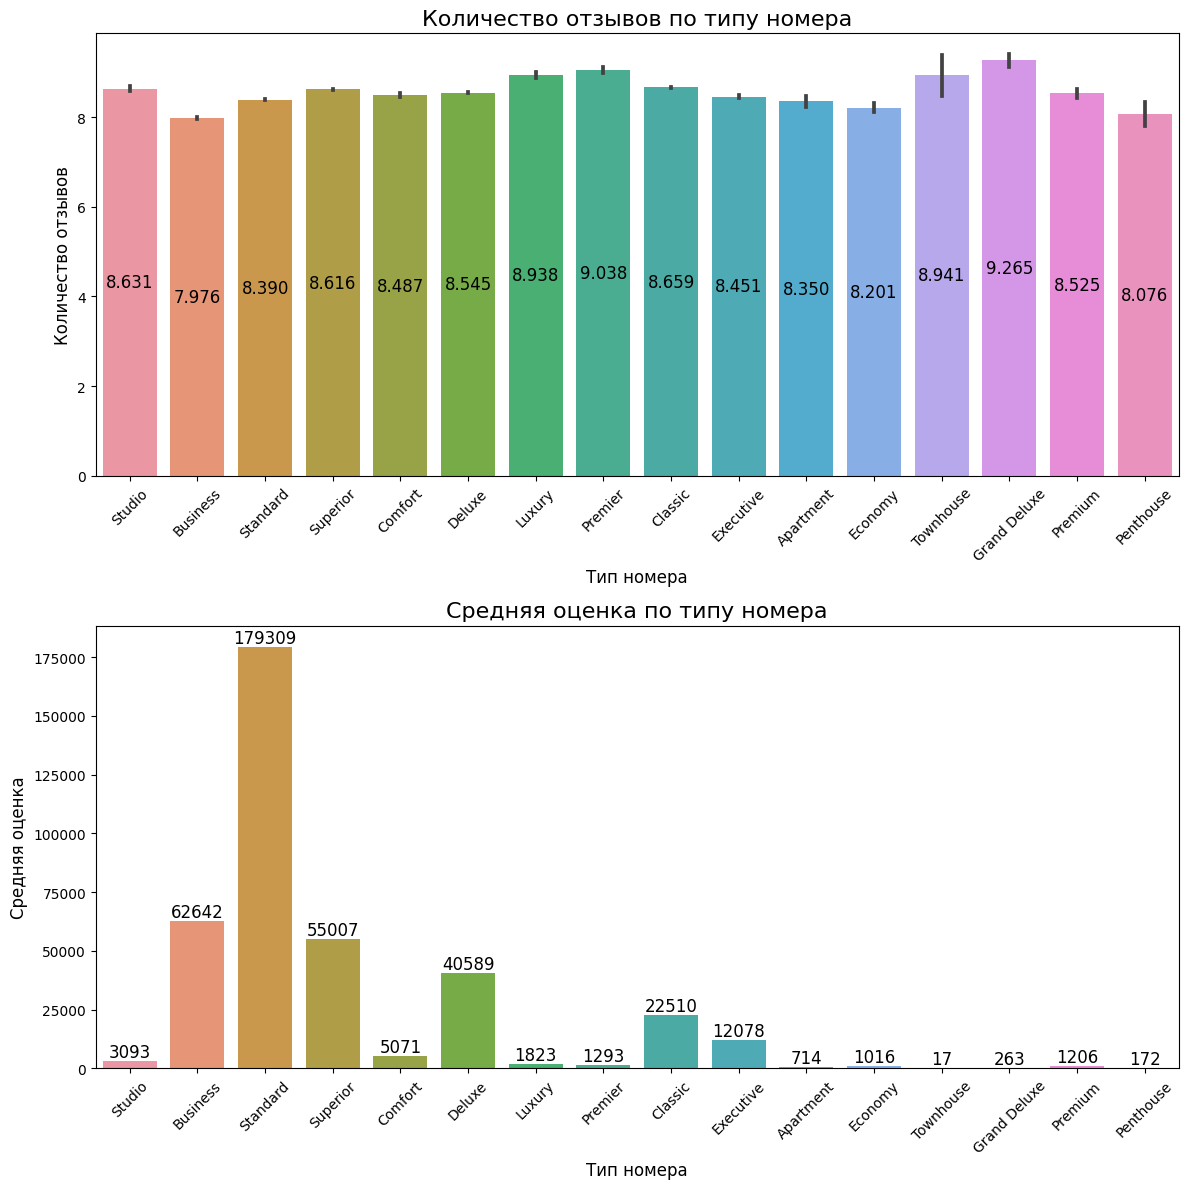

In [79]:
# создание полотна для графиков
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 12))

sns.barplot(
    data=hotels[hotels['sample'] == 1],
    x='room_class',
    y='reviewer_score',
    ax=ax[0]
)

sns.countplot(
    data=hotels[hotels['sample'] == 1],
    x='room_class',
    ax=ax[1])

# настройка первого графика
# настройка заголовка
ax[0].set_title('Количество отзывов по типу номера', size=16)
# настройка подписи оси х
ax[0].set_xlabel('Тип номера', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)
# настройка подписи оси у
ax[0].set_ylabel('Количество отзывов', fontsize=12)
# добавление значений в каждом баре
ax[0].bar_label(ax[0].containers[0], label_type='center', size=12, fmt='%.3f')

# настройка второго графика
# настройка заголовка
ax[1].set_title('Средняя оценка по типу номера', size=16)
# настройка подписи оси х
ax[1].set_xlabel('Тип номера', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)
# настройка подписи оси у
ax[1].set_ylabel('Средняя оценка', fontsize=12)
# добавлени значений в каждом баре
ax[1].bar_label(ax[1].containers[0], label_type='edge', size=12)

fig.tight_layout();

Больше всего отзывов на номер типа *Standard*. Самую низкую среднюю оценку имеет тип номера *Business* (7,976), самую высокую - *Grand Deluxe* (9,265). Средние оценки остальных типов номеров не сильно отличаются друг от друга.

### 3.6.8 Наличие Wifi

Добавим признак наличия wi-fi  в номере.

In [80]:
hotels['wifi'] = hotels['tags'].apply(lambda x: 'Есть' if 'wifi' in ' '.join(x).lower() or 'wi fi' in ' '.join(x).lower() or 'wi-fi' in ' '.join(x).lower() else 'Нет')

In [81]:
hotels['wifi'].value_counts()

Нет     515084
Есть       654
Name: wifi, dtype: int64

Количество отзывов о номерах, где был wi-fi крайне мало - всего 654. Этот признак не несет в себе ценности.

## 3.7 Дубликаты

Создание признака дубликатов. Добавим признак `duplicate`, в котором пометим отзывы, которые являются дубликатами (**0** - оригинальный отзыв, **1** - дубликат).

In [82]:
# добавим признак duplicate, который поможет идентифицировать дубликаты
hotels['duplicate'] = hotels.duplicated().apply(lambda x: 1 if x is True else 0)

In [83]:
# выведем количество дубликатов
hotels['duplicate'].value_counts()

0    515402
1       336
Name: duplicate, dtype: int64

## 3.8 Количество слов в отзывах *review_total_negative_word_counts* и *review_total_positive_word_counts*

Заменим значения в признаках *review_total_negative_word_counts* и *review_total_positive_word_counts* на более реальные. Сейчас значения в этих признаках не соответствуют количеству слов в отзывах.

In [84]:
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: len(x.split()))

## 3.9 Разница между количеством слов в положительном и отрицательном отзыве

Добавим признак `words_different`, в котором будет разница количества слов в положительном и отрицательном отзыве.

In [85]:
# создадим признак words_different
hotels['words_different'] = hotels['review_total_positive_word_counts'] - hotels['review_total_negative_word_counts']

In [86]:
# сгруппируем датасет по признаку words_different и посмотрим на оценки в зависимости от разницы слов
data = hotels[hotels['sample'] == 1].groupby('words_different')['reviewer_score'].mean().sort_index(ascending=False)
data

words_different
 381     5.40
 380     7.50
 374    10.00
 371    10.00
 369     8.30
        ...  
-388     6.30
-390     5.40
-394     7.10
-395     4.40
-398     3.15
Name: reviewer_score, Length: 714, dtype: float64

По полученным данным можно сделать следующее предположение:
- чем больше разница слов положительного и отрицательного отзыва, тем выше оценка отзыва;
- чем больше разница слов отрицательного и положительного отзыва, тем ниже оценка отзыва.

Попробуем это визуализировать.

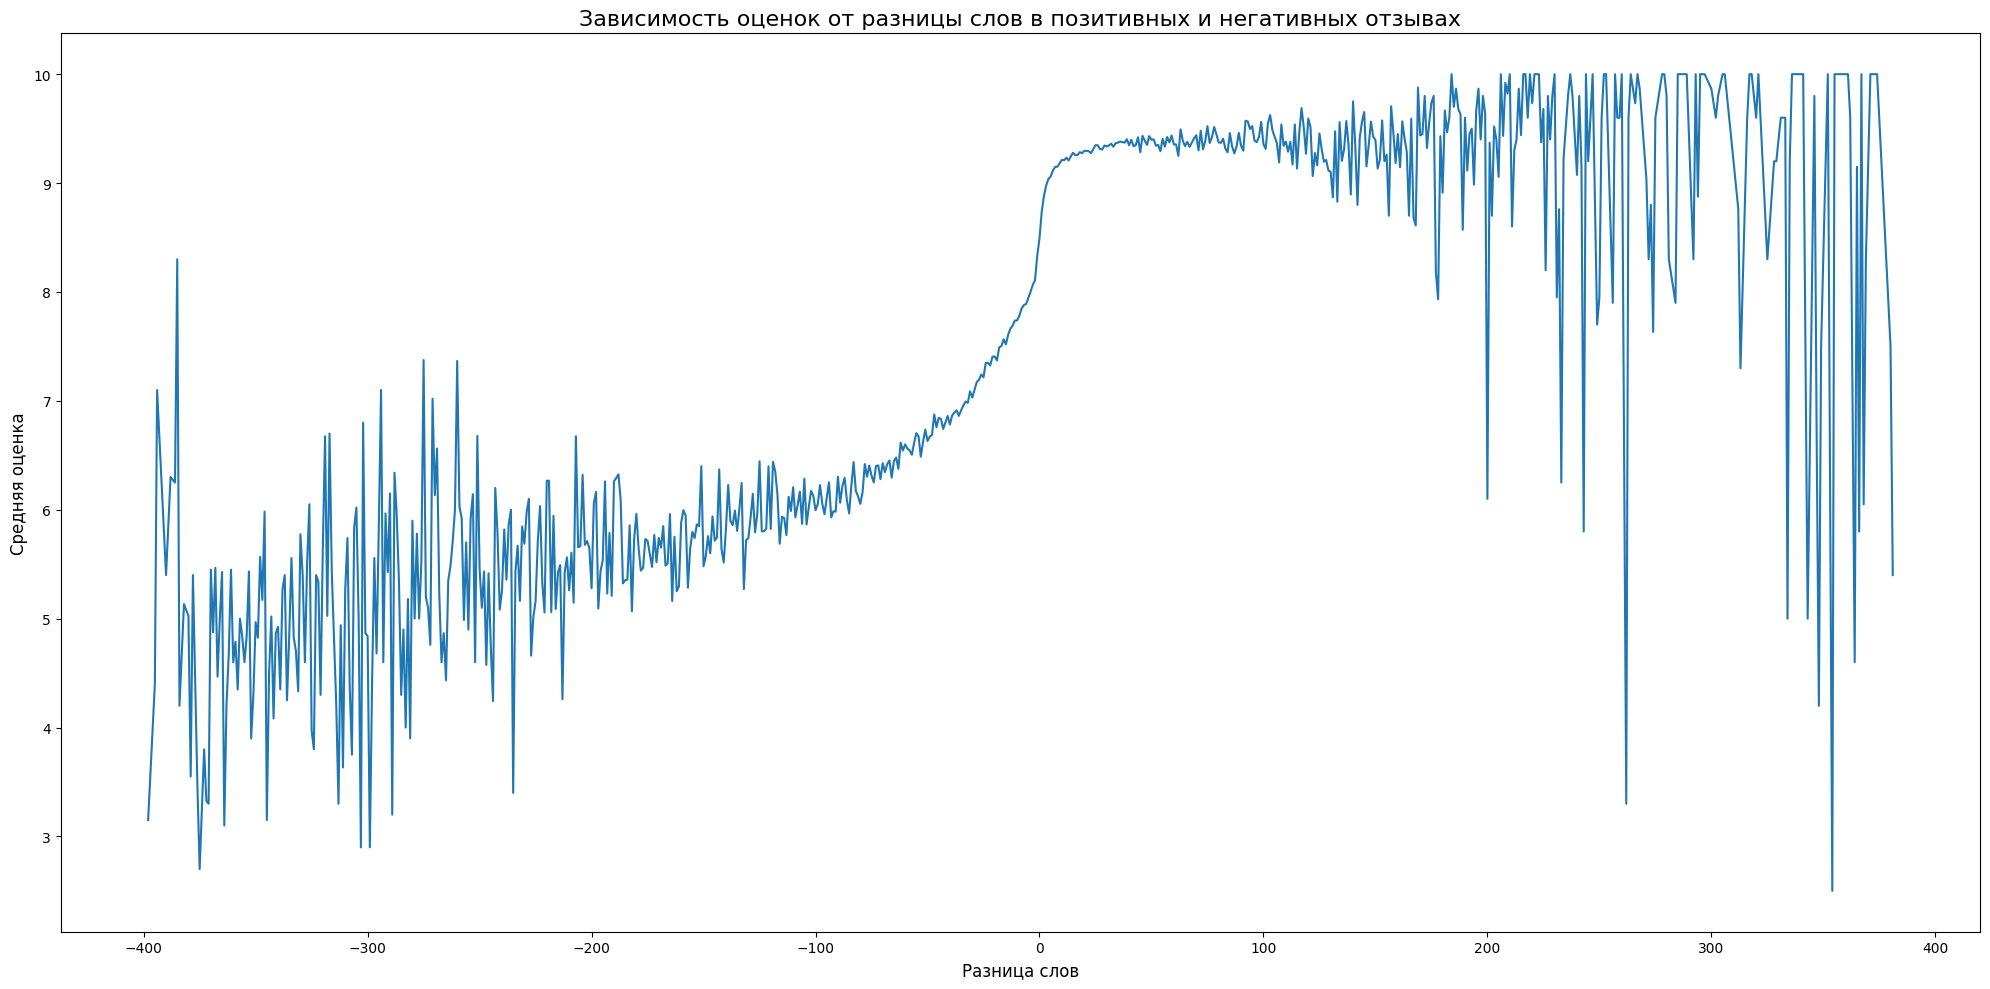

In [87]:
fig = plt.figure(figsize=(20, 10))

lineplot = sns.lineplot(
    data=data
)

lineplot.set_title('Зависимость оценок от разницы слов в позитивных и негативных отзывах', size=16)
# настройка подписи оси х
lineplot.set_xlabel('Разница слов', fontsize=12)
# настройка подписи оси у
lineplot.set_ylabel('Средняя оценка', fontsize=12)

fig.tight_layout();

Средняя оценка как будто снижается с увеличением разницы слов в позитивных и негативных отзывах. Но после разницы в 100 и -100 слов график начинает "прыгать", скакать вверх-вниз. К тому же, как можно заметить, что чем больше в негативном отзыве слов в сравнении с позитивным отзывом (чем меньше значение), тем ниже средняя оценка, и наоборот. Можно предположить, что если разница слов между позитивным и негативным отзывом отрицательная, то отзыв имеет низкую оценку и скорее является отрицательным, а если разница положительная, то отзыв имеет высокую оценку и скорее является положительным.

## 3.10 Предположение - позитивный, негативный или нейтральный отзывы

Создадим бинарные признаки `more_positive`, `more_negative` и `more_neutral`. Признаки заполняются следующим образом:
- если разница в количестве слов позитивного и негативного отзыва отрицательная, то отзыв считается скорее негативным, признак `more_negative` заполняется единицей, а `more_positive` и `more_neutral` - нулями;
- если разница положительная, то отзыв считается скорее позитивным, признак `more_positive` заполняется единицей, а `more_negative` и `more_neutral` - нулями;
- если разница слов равна нулю (вряд ли возможно, но почему бы и нет), то отзыв считается скорее нейтральным, признак `more_neutral` заполняется единицей, а `more_negative` и `more_positive` - нулями.

Приступим.

In [88]:
hotels['more_positive'] = hotels['words_different'].apply(lambda x: 1 if x > 0 else 0)
hotels['more_negative'] = hotels['words_different'].apply(lambda x: 1 if x < 0 else 0)
hotels['more_neutral'] = hotels['words_different'].apply(lambda x: 1 if x == 0 else 0)

In [89]:
more_pos_score = hotels[(hotels['sample'] == 1) & (hotels['more_positive'] == 1)]['reviewer_score'].mean()
more_pos_count = hotels[(hotels['sample'] == 1) & (hotels['more_positive'] == 1)]['reviewer_score'].count()

more_neg_score = hotels[(hotels['sample'] == 1) & (hotels['more_negative'] == 1)]['reviewer_score'].mean()
more_neg_count = hotels[(hotels['sample'] == 1) & (hotels['more_negative'] == 1)]['reviewer_score'].count()

more_neut_score = hotels[(hotels['sample'] == 1) & (hotels['more_neutral'] == 1)]['reviewer_score'].mean()
more_neut_count = hotels[(hotels['sample'] == 1) & (hotels['more_neutral'] == 1)]['reviewer_score'].count()

In [90]:
print(f'Позитивные отзывы: количество - {more_pos_count} из {hotels[hotels["sample"] == 1].shape[0]} ({round(more_pos_count / hotels[hotels["sample"] == 1].shape[0] * 100, 2)}%); средняя оценка - {round(more_pos_score, 3)}')
print(f'Негативные отзывы: количество - {more_neg_count} из {hotels[hotels["sample"] == 1].shape[0]} ({round(more_neg_count / hotels[hotels["sample"] == 1].shape[0] * 100, 2)}%); средняя оценка - {round(more_neg_score, 3)}')
print(f'Нейтральные отзывы: количество - {more_neut_count} из {hotels[hotels["sample"] == 1].shape[0]} ({round(more_neut_count / hotels[hotels["sample"] == 1].shape[0] * 100, 2)}%); средняя оценка - {round(more_neut_score, 3)}')

Позитивные отзывы: количество - 197453 из 386803 (51.05%); средняя оценка - 9.156
Негативные отзывы: количество - 172167 из 386803 (44.51%); средняя оценка - 7.517
Нейтральные отзывы: количество - 17183 из 386803 (4.44%); средняя оценка - 8.491


Как можно увидеть, скорее позитивных отзывов больше, чем скорее негативных почти на 5%.

## 3.11 Количество негативных и позитивных слов в отзывах

Попробуем своими силами разобраться какой отзыв на самом деле. Идея в том, чтобы выделить в отдельные списки слова, которые имеют в негативный оттенок и могут использоваться в негативном отзыве, позитивном позитивный оттенок и нейтральный. Если в отзыве находим слово из "негативного списка", увеличиваем счетчик "негативности" отзыва - количество негативных слов в отзыве. Аналогично с позитивным. С нейтральными интереснее: в нем собраны слова, которые могут использоваться как в позитивном отзыве, так и в негативном, например breakfast, room, size, location, everything, price. Завтрак может быть как хорошим, так и плохим; комнату могут похвалить, а могут поругать; размер номера может быть удовлетворительный, а может и нет; локация оказалась в удобном месте, либо отель находится в труднодоступном месте, и т.д. Если нейтральное слово встречается в негативном отзыве, то к счетчику негативных слов добавляются нейтральные. Аналогично с позитивным отзывом.

Для отбора слов пришлось собрать все слова всех отзывов в один список, сделать из него счетчик с помощью библиотеки `collections` и класса `Counter()` и рассмотреть самые популярные (все слова рассматривать вручную это лихо, на такое не решился). В итоге получилось три списка:

In [91]:
positive_words = ['no negative', 'no negatives', 'no dislikes', 'no problems', 'no complaints', 'good', 'ok', 'nil', 'was perfect', 'was great', 'was good',
                  'was fine', 'was good', 'was all good', 'leaving', 'leave', 'liked', 'loved', 'no thing', 'not a thing', 'nothing at all', 'nothing', 'anything', 'friendly', 'helpful', 'excellent',
                  'perfect', 'comfy', 'comfortable', 'clean', 'great', 'convenient', 'nice', 'fantastic', 'cleanliness', 'value for money','yes']

negative_words = ['no positive', 'small', 'expensive', 'not applicable', 'not included', 'no parking', 'poor', 'not much', 'noisy', 'too', 'no lift', 'no bath', 'noise', 'tiny']

neutral_words = ['breakfast', 'room', 'rooms', 'size', 'location', 'everything', 'every thing', 'price', 'cost', 'staff', 'wifi', 'pillows', 'parking', 'bed', 'position', 'service', 'prices', 'food', 'view']

Создадим функции, которые помогут нам посчитать количество негативных и позитивных слов в негативных и позитивных отзывах.
- функция `get_positive_words_count_in_positive_review`: считает количество позитивных слов в позитивном отзыве; принимает позитивный отзыв, список с позитивными словами и список с нейтральными словами; как выше уже было замечено, в позитивном отзыве нейтральные слова могут означать положительный контекст, поэтому если в отзыве есть слова из списков нейтральных и позитивных слов, увеличиваем счетчик позитивных слов;
- функция `get_positive_words_count_in_negative_review`: считает количество позитивных слов в негативном отзыве; принимает негативный отзыв и список с позитивными словами; здесь уже нет списка с нейтральными словами, так как они могут относиться к минусам отеля, поэтому если в отзыве есть слова из списка позитивных слов, увеличиваем счетчик позитивных слов;
- функция `get_negative_words_count_in_negative_review`: считает количество негативных слов в негативном отзыве; принимает негативный отзыв, список с негативными словами и список с нейтральными словами; как выше уже было замечено, в негативном отзыве нейтральные слова могут означать отрицательный контекст, поэтому если в отзыве есть слова из списков нейтральных и негативных слов, увеличиваем счетчик негативных слов;
- функция `get_negative_words_count_in_positive_review`: считает количество негативных слов в позитивном отзыве; принимает позитивный отзыв и список с негативными словами; здесь так же нет списка с нейтральными словами, так как они могут относиться к плюсам отеля, поэтому если в отзыве есть слова из списка негативных слов, увеличиваем счетчик негативных слов.

In [92]:
def get_positive_words_count_in_positive_review(review, positive_words, neutral_words) -> int:
    '''
    Возвращает количество позитивных слов в позитивном отзыве.
    
            Параметры:
                    review (str): позитивный отзыв
                    positive_words (list): список позитивных слов
                    neutral_words (list): список нейтральных слов
                    
            Возвращаемое значение:
                    count (int): количество позитивных слов в позитивном отзыве
    '''
    count = 0
    for lst in [positive_words, neutral_words]:
        for word in lst:
            if word in review.lower():
                count += 1
    return count


def get_positive_words_count_in_negative_review(review, positive_words) -> int:
    '''
    Возвращает количество позитивных слов в негативном отзыве.
    
            Параметры:
                    review (str): негативный отзыв
                    positive_words (list): список позитивных слов
                    
            Возвращаемое значение:
                    count (int): количество позитивных слов в негативном отзыве
    '''
    count = 0
    for word in positive_words:
        if word in review.lower():
            count += 1
    return count


def get_negative_words_count_in_negative_review(review, negative_words, neutral_words) -> int:
    '''
    Возвращает количество негативных слов в негативном отзыве.
    
            Параметры:
                    review (str): негативный отзыв
                    negative_words (list): список негативных слов
                    neutral_words (list): список нейтральных слов
                    
            Возвращаемое значение:
                    count (int): количество негативных слов в негативном отзыве
    '''
    count = 0
    for lst in [negative_words, neutral_words]:
        for word in lst:
            if word in review.lower():
                count += 1
    return count


def get_negative_words_count_in_positive_review(review, negative_words) -> int:
    '''
    Возвращает количество негативных слов в позитивном отзыве.
    
            Параметры:
                    review (str): позитивный отзыв
                    negative_words (list): список негативных слов
                    
            Возвращаемое значение:
                    count (int): количество негативных слов в позитивном отзыве
    '''
    count = 0
    for word in negative_words:
        if word in review.lower():
            count += 1
    return count

In [93]:
hotels['pos_in_pos'] = hotels['positive_review'].apply(lambda x: get_positive_words_count_in_positive_review(x, positive_words, neutral_words))
hotels['pos_in_neg'] = hotels['negative_review'].apply(lambda x: get_positive_words_count_in_negative_review(x, positive_words))
hotels['neg_in_neg'] = hotels['negative_review'].apply(lambda x: get_negative_words_count_in_negative_review(x, negative_words, neutral_words))
hotels['neg_in_pos'] = hotels['positive_review'].apply(lambda x: get_negative_words_count_in_positive_review(x, negative_words))

In [94]:
data = hotels[hotels['sample'] == 1][['pos_in_pos', 'pos_in_neg', 'neg_in_neg', 'neg_in_pos', 'reviewer_score']]
data

,pos_in_pos,pos_in_neg,neg_in_neg,neg_in_pos,reviewer_score
0,1,1,0,0,10.0
1,1,0,2,0,6.3
2,0,0,1,1,7.5
3,7,1,0,0,10.0
4,6,0,0,0,9.6
...,...,...,...,...,...
386798,0,1,0,0,8.8
386799,6,1,0,0,9.2
386800,3,0,2,0,8.3
386801,3,1,0,0,9.2


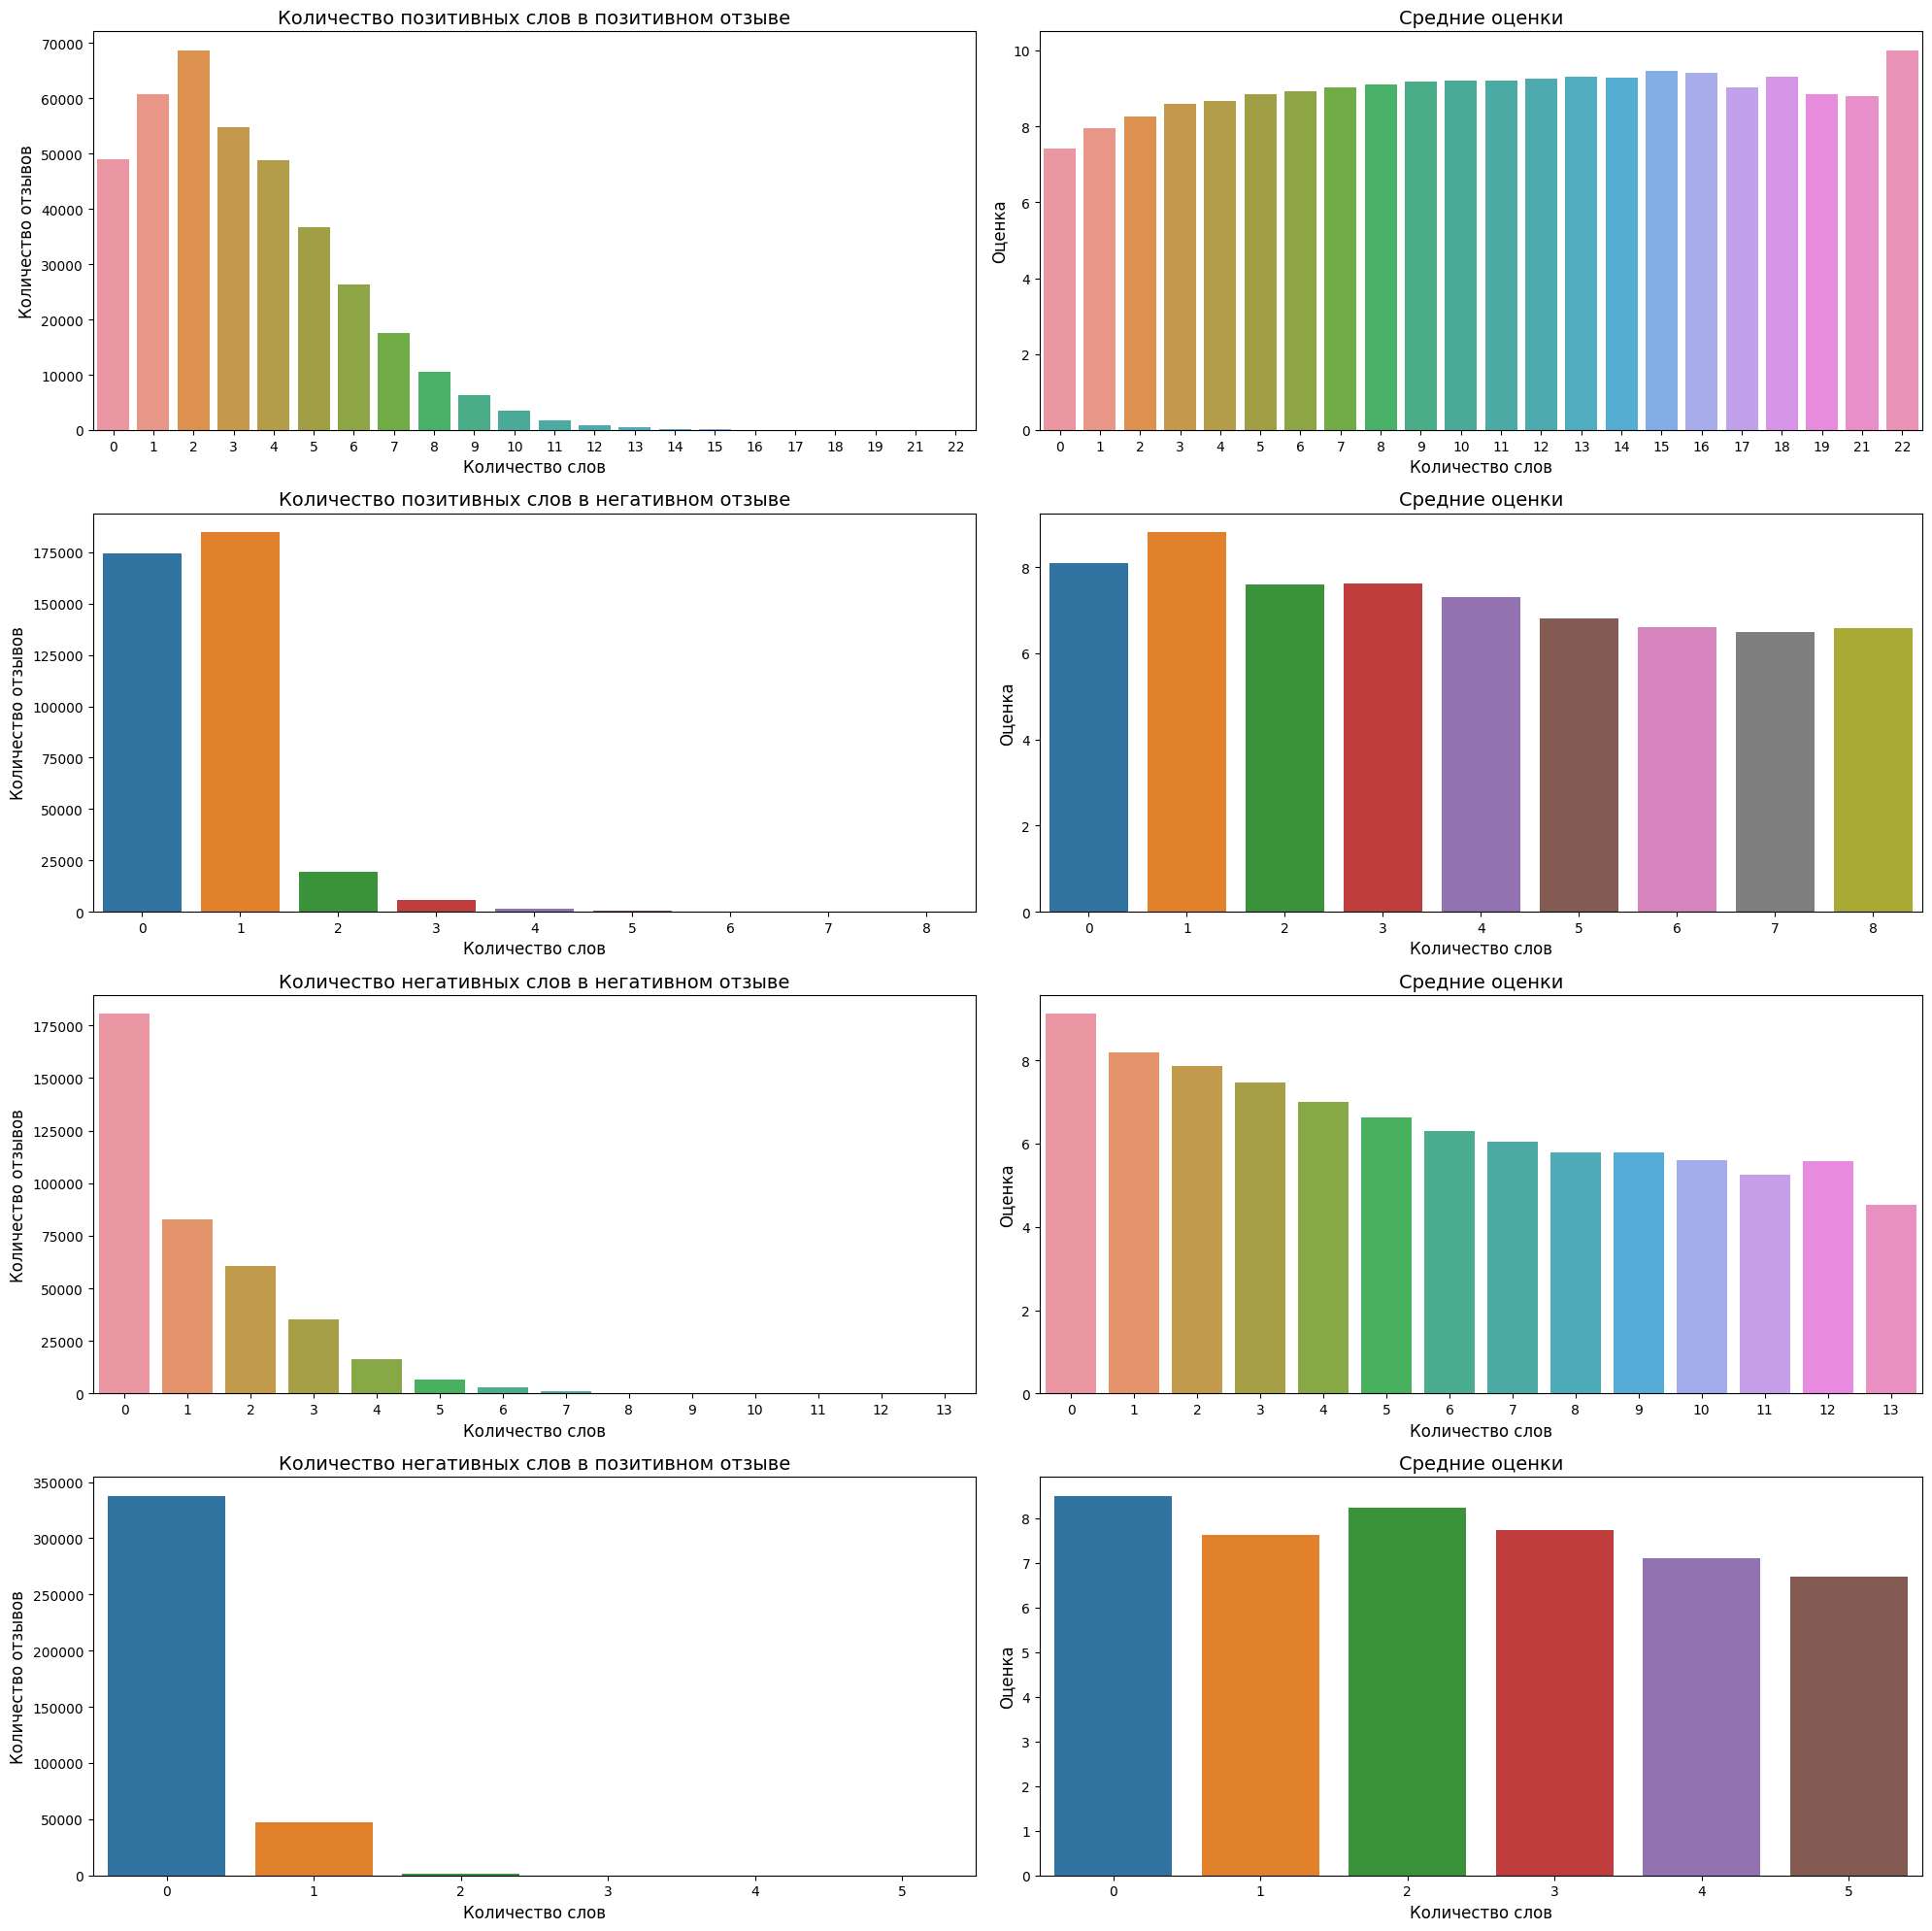

In [95]:
# построение полотна для графиков
names = ['Количество позитивных слов в позитивном отзыве',
         'Количество позитивных слов в негативном отзыве', 
         'Количество негативных слов в негативном отзыве',
         'Количество негативных слов в позитивном отзыве'
        ]
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))

futures = ['pos_in_pos', 'pos_in_neg', 'neg_in_neg', 'neg_in_pos']

for i in range(4):
    sns.barplot(
        x=list(data[futures[i]].value_counts().index),
        y=list(data[futures[i]].value_counts().values),
        ax=ax[i, 0])

    # настройка заголовка
    ax[i, 0].set_title(names[i], size=14)
    # настройка подписи оси х
    ax[i, 0].set_xlabel('Количество слов', fontsize=12)
    # настройка подписи оси у
    ax[i, 0].set_ylabel('Количество отзывов', fontsize=12)
    
    table = hotels[hotels['sample'] == 1].groupby(futures[i])['reviewer_score'].mean()
    sns.barplot(
        x=list(table.index),
        y=list(table.values),
        ax=ax[i, 1])

    # настройка заголовка
    ax[i, 1].set_title('Средние оценки', size=14)
    # настройка подписи оси х
    ax[i, 1].set_xlabel('Количество слов', fontsize=12)
    # настройка подписи оси у
    ax[i, 1].set_ylabel('Оценка', fontsize=12)

fig.tight_layout();

По данным графиков получается, что
- чем больше позитивных слов в позитивной части отзыва, тем выше оценка (см. график в сетке: строка 1, столбец 2);
- чем больше негативных слов в негативной части отзыва, тем ниже оценка (см. график в сетке: строка 3, столбец 2).

По остальным показателям нельзя однозначно сделать выводы, но чуть заметно прослеживается тенденция на убывание: чем больше позитивных слов в негативной части отзыва, тем оценка ниже, и чем больше негативных слов в позитивной части отзыва, тем оценка ниже.

Следует учесть, что количество отзывов, где слов больше 5-10, мало, поэтому доверять на 100% этим оценка не стоит. Но принять в работу можно.

# 4. Отбор признаков

Рассмотрим какие признаки у нас получились:

In [96]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

Признаки, которые подлежат удалению:
-  hotel_address (все, что можно, мы из него получили);
-  review_date (оценки примерно одинаковые на всех временных промежутках);
-  hotel_name;
-  reviewer_nationality (оценки туристов и коренных жителей практически не отличаются);
-  negative_review (из негативного отзыва получили все, что хотели);
-  positive_review (так же, как и из позитивного);
-  tags;
-  lat;
-  lng;
-  country (из-за того, что в каждой стране по одному городу, признак *country* и *city* дублируют друг друга; оставим и закодируем признак *city*);
-  postcode (так и не пригодился);
-  distance_to_center (так как мы преобразовали его в distance_category);
-  day;
-  day_of_week;
-  month;
-  period;
-  native;
-  submitted_mobile;
-  with_a_pet.

Сбросим их, но сперва сделаем копию датасета (на всякий случай):

In [97]:
data = hotels.copy()

In [98]:
data.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'lat', 'lng',
             'country', 'postcode', 'distance_to_center', 'day', 'day_of_week', 'month', 'period', 'native', 'submitted_mobile', 'with_a_pet'],
           axis=1, inplace=True)

Посмотрим что осталось:

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   days_since_review                           515738 non-null  int64  
 8   sample                                      515738 non-null  int64  
 9   city                                        515738 non-null  object 
 

Признаки, которые можно преобразовать в бинарные:
- city;
- travel_company;
- trip_type;
- room_class.

Выполним для каждого признака "горячее кодирование". Все признаки имеют небольшое количество уникальных значений.

In [100]:
data = pd.get_dummies(data, columns=['city', 'travel_company', 'trip_type', 'room_class'], drop_first=True)

# 5. Матрица корреляции

Построим матрицу корреляции и проанализируем зависимости имеющихся признаков между собой:

C:\Users\User\AppData\Local\Temp\ipykernel_13808\4228132886.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr(),


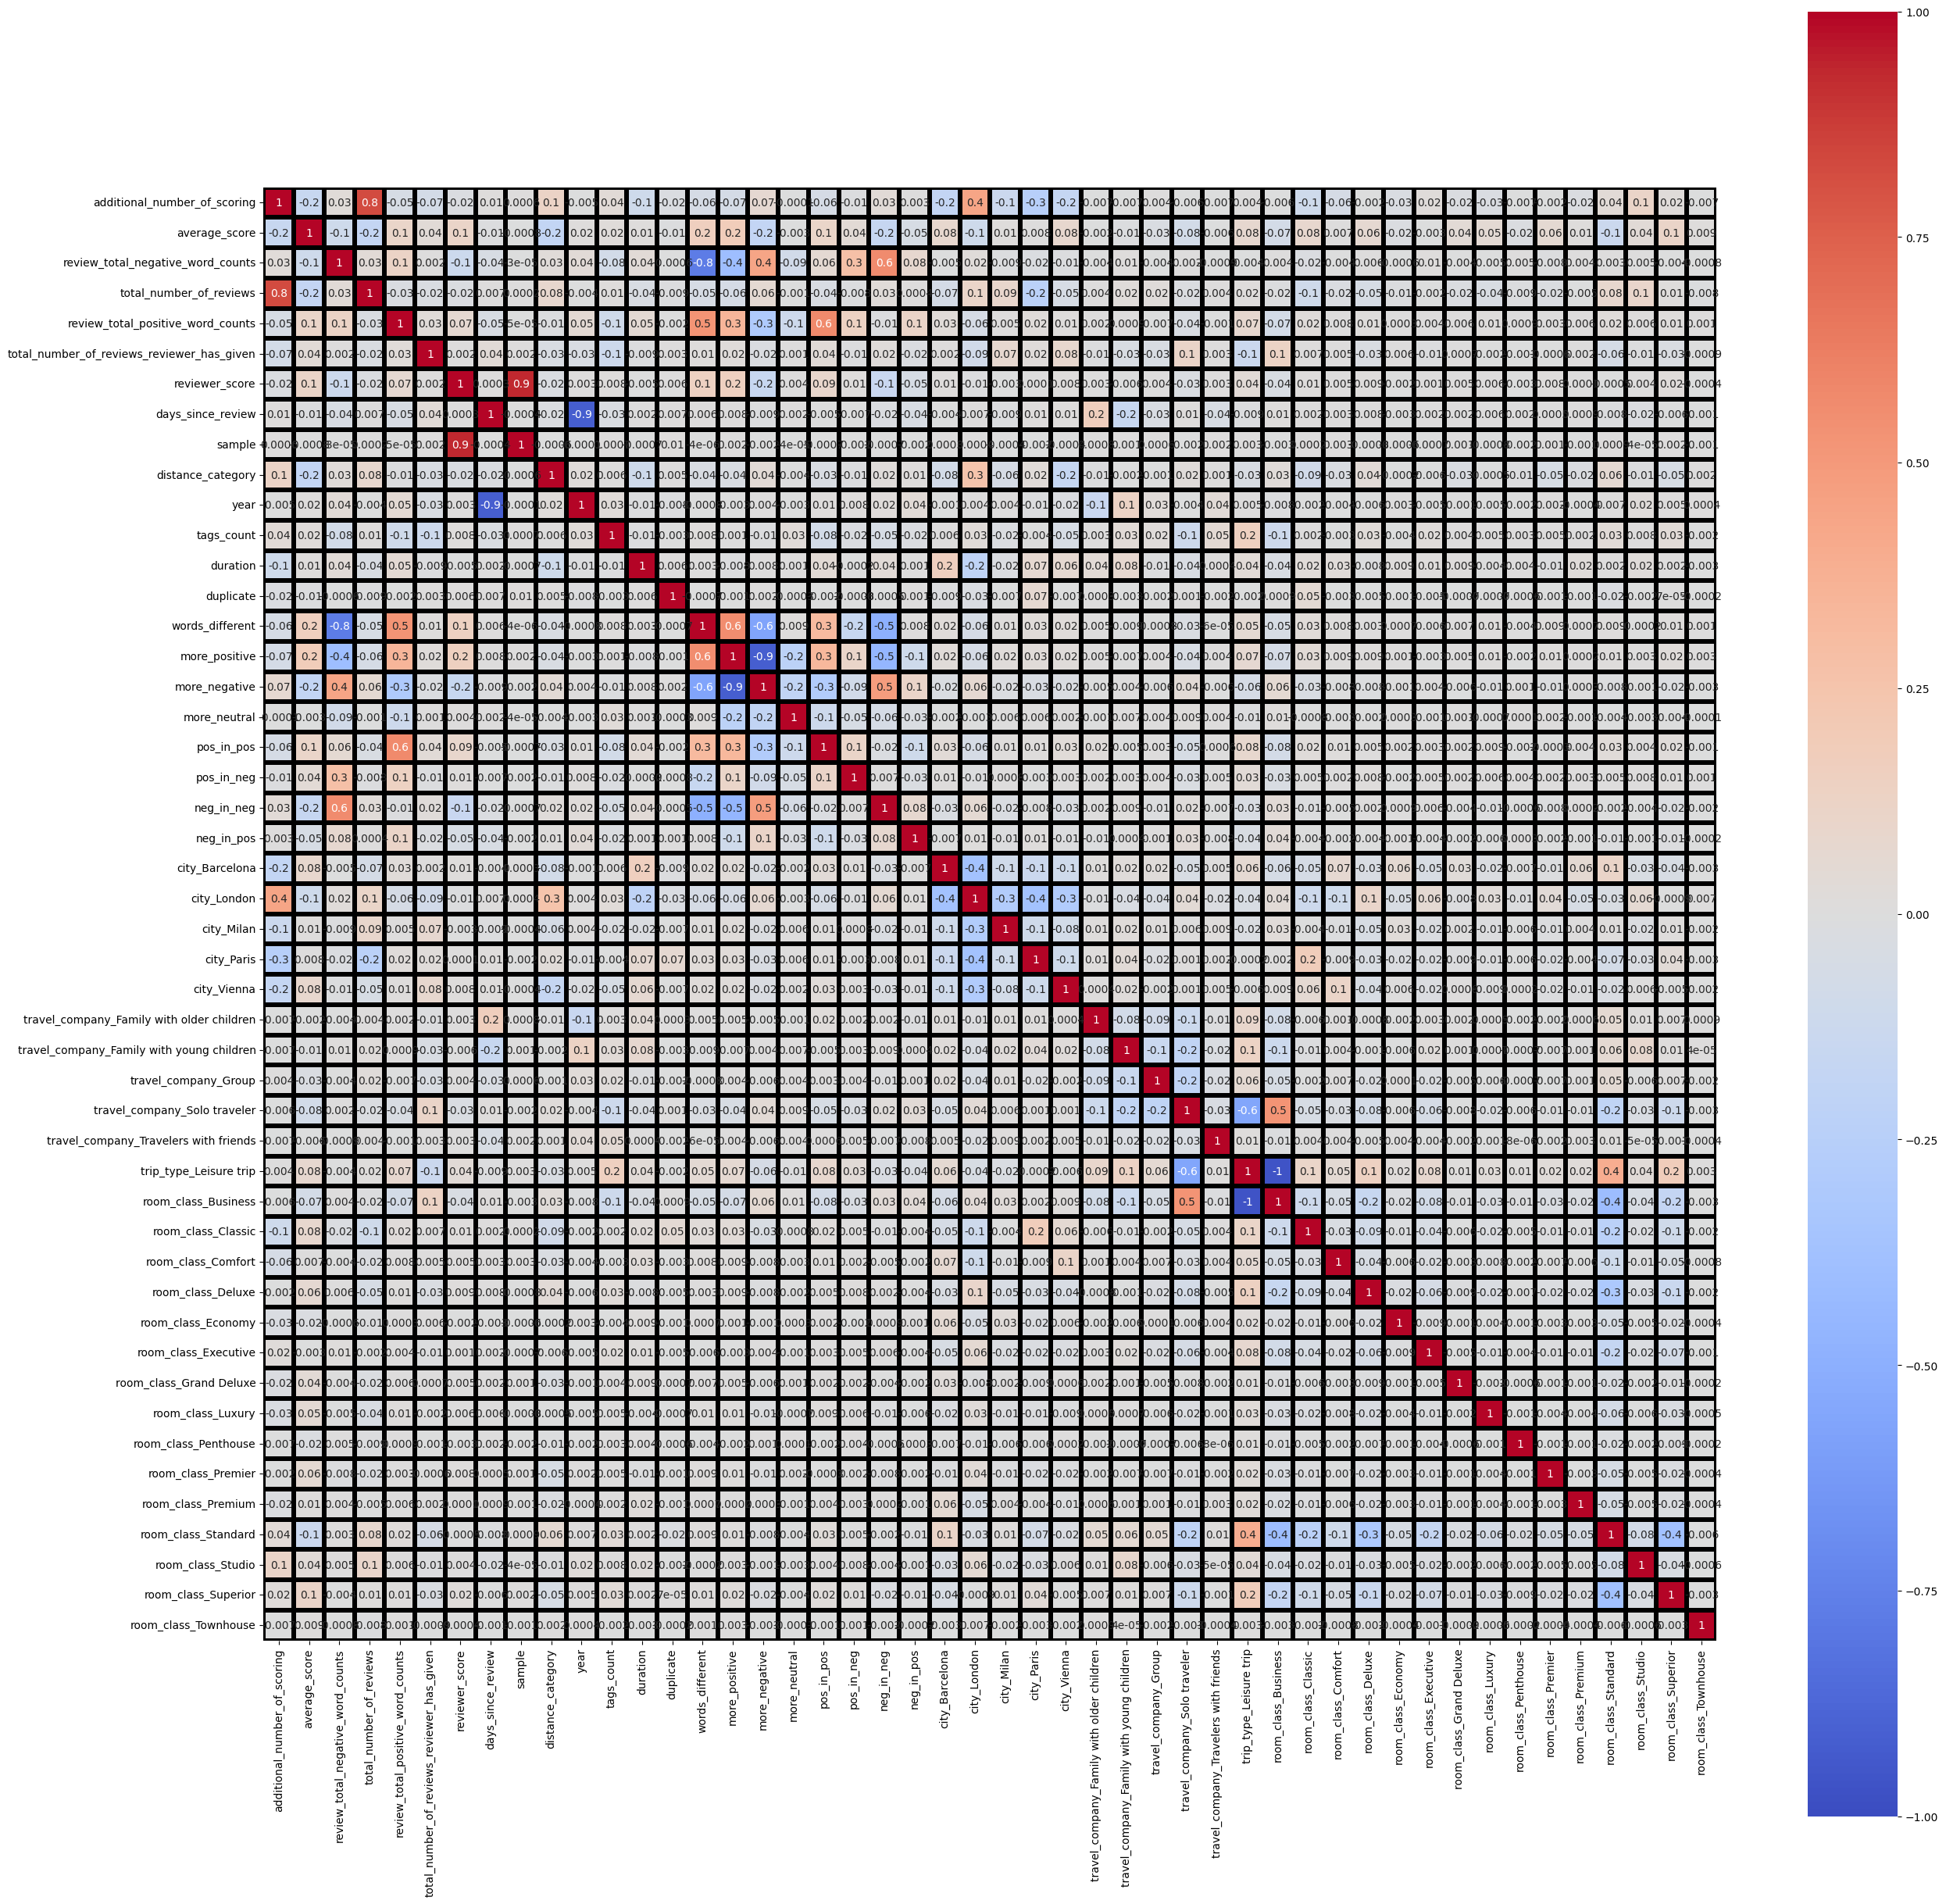

In [101]:
fig, ax = plt.subplots(figsize=(30, 30))

sns.heatmap(
    data.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.1g',
    vmin=-1,
    vmax=1,
    center=0,
    linewidth=3,
    linecolor='black',
    square=True,
    ax=ax
);

Видим, что есть несколько пар признаков с сильной корреляцией (больше 0,7):
- *total_numder_of_reviews* и *additional_number_of_scoring*;
- *year* и *days_since_review*;
- *sample* и *review_score*;
- *words_different* и *review_total_negative_word_counts*;
- *more_negative* и *more_positive*;
- *room_class_Business* и *trip_type_Leisure_trip*.

Оставим следующие:
- *total_numder_of_reviews* - общее количество действительных отзывов об отеле, не будем учитывать отзывы без проверки (*additional_number_of_scoring*);
- *days_since_review*, уберем признак *year*;
- *sample* нужен далее для разбивки датасета, *review_score* дропнем там же;
- *words_different*;
- *more_positive* - оставим предположение о позитивности отзыва;
- *trip_type_Leisure_trip*.

In [102]:
data.drop(['additional_number_of_scoring', 'year', 'review_total_negative_word_counts', 'more_negative', 'room_class_Business'], axis=1, inplace=True)
data['wifi'] = data['wifi'].apply(lambda x: 1 if x == "Да" else 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   total_number_of_reviews                     515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   reviewer_score                              515738 non-null  float64
 5   days_since_review                           515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   distance_category                           515738 non-null  int64  
 8   tags_count                                  515738 non-null  int64  
 9   duration                                    515738 non-null  int64  
 

# 6. Создание и обучение модели

Начнем работать с моделью:

In [103]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [104]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [105]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 43), (386803, 43), (386803, 42), (309442, 42), (77361, 42))

In [106]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [107]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [108]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [109]:
# НЕ ТО!!!!!!!!!!!!!!!!!!!!
# НИЖЕ ТО!!!!!!!

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [110]:
import numpy as np
 
# Функция для вычисления MAPE
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [111]:
# ТО, ЧТО НАДО!!!
MAE = mape_func(y_test, y_pred)
print(MAE)

13.082549747471022


<AxesSubplot: >

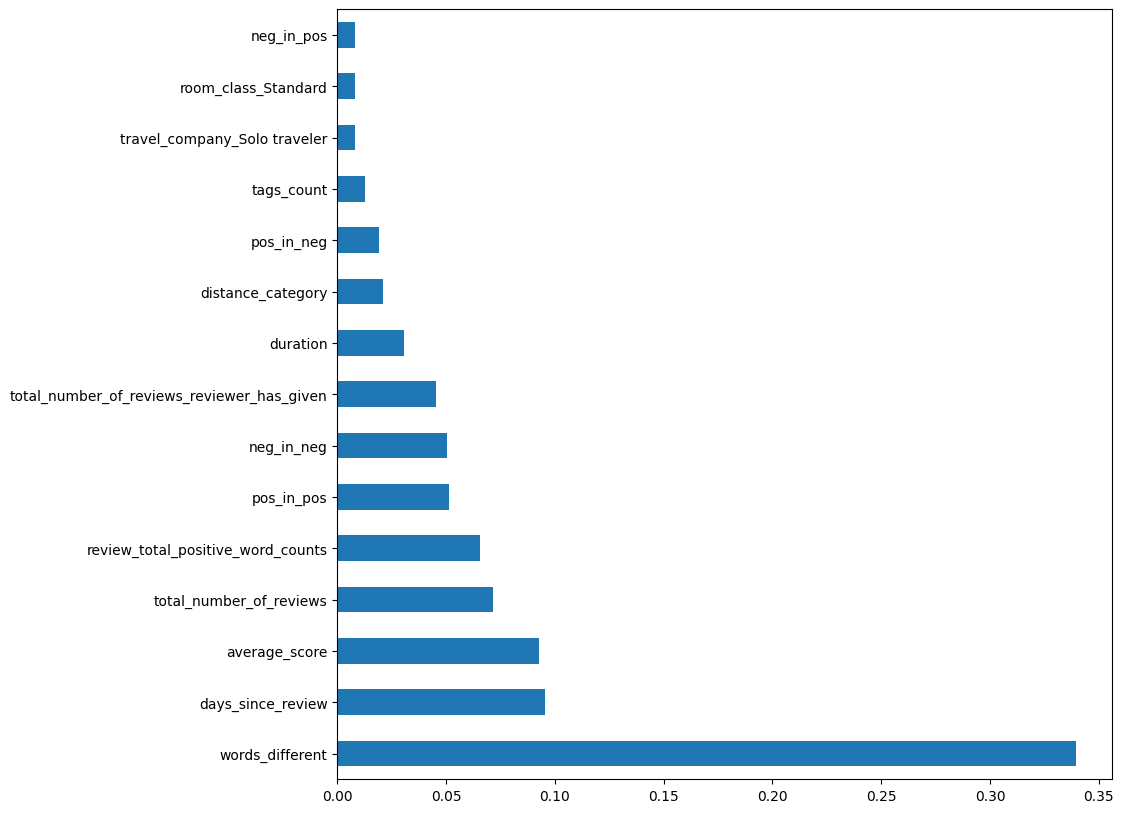

In [112]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Наибольшее влияние оказывают признаки, которые связаны с текстом отзывов, то есть разница слов между положительной частью отзыва и отрицательной (*words_difference*), количество позитивных и негативных слов в отзывах (*pos_in_pos*, *neg_in_neg*). Хочется заметить следующее. Во время разработки проекта на черновике не удалось найти значимых взаимосвязей между признаками с помощью различных гипотез. Дело особо не двигалось с места, необходимый минимальный показатель MAE не достигался. Но дело сдвинулось с места, когда пошел анализ текса отзыва и выделение *позитивных* и *негативных* слов. Можно сделать предположение, что анализируя отзывы, можно добиться лучших результатов. Но вручную это тяжело, так как отзывов очень много и все они разные по длине.

In [113]:
test_data.sample(10)

,average_score,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,distance_category,tags_count,duration,wifi,...,room_class_Executive,room_class_Grand Deluxe,room_class_Luxury,room_class_Penthouse,room_class_Premier,room_class_Premium,room_class_Standard,room_class_Studio,room_class_Superior,room_class_Townhouse
455314,9.3,1608,2,1,0.0,311,2,4,6,0,...,0,0,0,0,0,0,1,0,0,0
422229,8.6,2685,14,3,0.0,643,3,5,3,0,...,0,0,0,0,0,0,1,0,0,0
422259,8.1,1257,9,5,0.0,516,2,5,3,0,...,0,0,0,0,0,0,0,0,1,0
515363,9.2,4017,1,20,0.0,314,3,5,1,0,...,0,0,0,0,0,0,0,0,0,0
396077,8.1,1560,2,1,0.0,83,3,5,3,0,...,0,0,0,0,0,0,1,0,0,0
454287,7.9,6792,4,1,0.0,330,3,5,3,0,...,0,0,0,0,0,0,1,0,0,0
484200,7.9,3130,26,16,0.0,302,2,5,1,0,...,0,0,0,0,0,0,1,0,0,0
387755,8.1,2436,14,16,0.0,540,3,5,5,0,...,0,0,0,0,0,0,1,0,0,0
510068,8.5,2775,26,4,0.0,121,2,5,3,0,...,0,0,0,0,0,0,1,0,0,0
510602,8.1,1294,1,12,0.0,730,3,4,1,0,...,0,0,0,0,0,0,1,0,0,0


In [114]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [115]:
sample_submission

,reviewer_score,id
0,8.641,488440
1,6.875,274649
2,8.022,374688
3,9.665,404352
4,9.677,451596
...,...,...
128930,8.886,495812
128931,9.063,315577
128932,8.078,511968
128933,9.624,303386


In [116]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


In [117]:
predict_submission

array([8.709, 6.879, 8.017, ..., 8.078, 9.625, 6.42 ])

In [118]:
list(sample_submission)

['reviewer_score', 'id']

In [119]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.709,488440
1,6.879,274649
2,8.017,374688
3,9.645,404352
4,9.684,451596
5,8.700,302161
6,8.347,317079
7,7.114,13963
8,8.616,159785
9,7.998,195089
